In [1]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GRU,Dropout,SimpleRNN
from keras.optimizers import SGD
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 100})

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set()
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 100})

In [3]:
df = pd.read_csv('iig_bharati.csv')
df.obstime = pd.to_datetime(df.obstime)
df.set_index('obstime', inplace=True)
size=df.size
orig=df
size=size-df.size
df=df[df.tempr>-100]
print(df)

                     tempr     rh     ws      wd      ap
obstime                                                 
2012-01-28 12:00:00  -0.33  34.24   4.51  155.95  982.00
2012-01-28 13:00:00  -0.44  38.07   4.19  149.70  982.02
2012-01-28 14:00:00   0.02  40.88   4.06  149.46  981.18
2012-01-28 15:00:00  -0.15  43.44   2.95  118.61  980.60
2012-01-28 16:00:00   0.06  44.14   3.14  134.17  979.63
2012-01-28 17:00:00  -0.01  44.95   5.26  162.08  978.77
2012-01-28 18:00:00  -0.45  45.08   5.99  161.67  977.67
2012-01-28 19:00:00  -1.47  46.45   6.91  173.04  976.78
2012-01-28 20:00:00  -2.64  48.30   7.73  176.25  976.00
2012-01-28 21:00:00  -3.20  46.03   8.13  177.10  975.40
2012-01-28 22:00:00  -3.51  42.65   8.74  174.12  974.62
2012-01-28 23:00:00  -3.61  40.92   9.09  172.05  974.00
2012-01-29 00:00:00  -3.85  42.39   8.58  174.54  973.07
2012-01-29 01:00:00  -4.44  44.62  10.07  175.72  972.28
2012-01-29 02:00:00  -5.11  46.86  10.50  176.11  971.15
2012-01-29 03:00:00  -5.21  46.

In [4]:

#df_month = df.resample('M').mean()
#temp = df_month[['temp']]
#temp.dropna(inplace=True)

In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
#df=df.last(30)
raw_values2 = df['tempr'].values
raw_values=raw_values2[:int(0.7*raw_values2.size)]
testX=raw_values2[int(0.7*raw_values2.size):]
# print(raw_values)

In [17]:
n_steps = 24
X, y = split_sequence(raw_values, n_steps)
for i in range(len(raw_values)-n_steps):
    print( X[i], y[i])
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

[-0.33 -0.44  0.02 -0.15  0.06 -0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61
 -3.85 -4.44 -5.11 -5.21 -5.06 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79] -1.13
[-0.44  0.02 -0.15  0.06 -0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85
 -4.44 -5.11 -5.21 -5.06 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79 -1.13] 0.52
[ 0.02 -0.15  0.06 -0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85 -4.44
 -5.11 -5.21 -5.06 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79 -1.13  0.52] 1.12
[-0.15  0.06 -0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85 -4.44 -5.11
 -5.21 -5.06 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79 -1.13  0.52  1.12] 1.12
[ 0.06 -0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85 -4.44 -5.11 -5.21
 -5.06 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79 -1.13  0.52  1.12  1.12] 0.99
[-0.01 -0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85 -4.44 -5.11 -5.21 -5.06
 -4.98 -4.43 -3.88 -3.3  -2.96 -2.3  -1.79 -1.13  0.52  1.12  1.12  0.99] 0.63
[-0.45 -1.47 -2.64 -3.2  -3.51 -3.61 -3.85 -4.44 -5.11 -5.21 -5.06 -4.98
 -4.43 -3.88 -

 -4.9  -4.11 -3.42 -2.89 -2.62 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14] -2.37
[-6.53 -7.23 -7.85 -8.4  -8.52 -8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9
 -4.11 -3.42 -2.89 -2.62 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37] -2.77
[-7.23 -7.85 -8.4  -8.52 -8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9  -4.11
 -3.42 -2.89 -2.62 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37 -2.77] -3.48
[-7.85 -8.4  -8.52 -8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9  -4.11 -3.42
 -2.89 -2.62 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37 -2.77 -3.48] -3.71
[-8.4  -8.52 -8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9  -4.11 -3.42 -2.89
 -2.62 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37 -2.77 -3.48 -3.71] -3.77
[-8.52 -8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9  -4.11 -3.42 -2.89 -2.62
 -2.14 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37 -2.77 -3.48 -3.71 -3.77] -3.89
[-8.78 -8.93 -9.01 -8.67 -7.52 -6.07 -4.9  -4.11 -3.42 -2.89 -2.62 -2.14
 -1.72 -1.5  -1.91 -1.2  -2.07 -2.14 -2.37 -2.77 -3.48 -3.71 -3.77 -3.89] -4.35
[-8

 -9.29 -9.22 -9.08 -8.83 -8.31 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52] -4.16
[-2.72 -3.5  -4.37 -4.93 -5.94 -5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29
 -9.22 -9.08 -8.83 -8.31 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16] -4.2
[-3.5  -4.37 -4.93 -5.94 -5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29 -9.22
 -9.08 -8.83 -8.31 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16 -4.2 ] -4.52
[-4.37 -4.93 -5.94 -5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29 -9.22 -9.08
 -8.83 -8.31 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16 -4.2  -4.52] -4.65
[-4.93 -5.94 -5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29 -9.22 -9.08 -8.83
 -8.31 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16 -4.2  -4.52 -4.65] -5.33
[-5.94 -5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29 -9.22 -9.08 -8.83 -8.31
 -7.59 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16 -4.2  -4.52 -4.65 -5.33] -6.02
[-5.82 -6.47 -6.74 -7.55 -8.04 -8.58 -9.29 -9.22 -9.08 -8.83 -8.31 -7.59
 -7.55 -6.61 -5.53 -5.41 -5.15 -4.52 -4.16 -4.2  -4.52 -4.65 -5.33 -6.02] -7.14
[-6

  -7.62  -7.46  -7.46  -7.38] -7.59
[ -8.71  -8.36  -8.7   -9.68 -10.7  -10.13 -10.3  -10.32 -10.68 -10.45
 -10.53  -9.97  -9.05  -8.69  -8.13  -7.34  -7.37  -7.64  -7.59  -7.62
  -7.46  -7.46  -7.38  -7.59] -7.91
[ -8.36  -8.7   -9.68 -10.7  -10.13 -10.3  -10.32 -10.68 -10.45 -10.53
  -9.97  -9.05  -8.69  -8.13  -7.34  -7.37  -7.64  -7.59  -7.62  -7.46
  -7.46  -7.38  -7.59  -7.91] -8.07
[ -8.7   -9.68 -10.7  -10.13 -10.3  -10.32 -10.68 -10.45 -10.53  -9.97
  -9.05  -8.69  -8.13  -7.34  -7.37  -7.64  -7.59  -7.62  -7.46  -7.46
  -7.38  -7.59  -7.91  -8.07] -8.05
[ -9.68 -10.7  -10.13 -10.3  -10.32 -10.68 -10.45 -10.53  -9.97  -9.05
  -8.69  -8.13  -7.34  -7.37  -7.64  -7.59  -7.62  -7.46  -7.46  -7.38
  -7.59  -7.91  -8.07  -8.05] -7.97
[-10.7  -10.13 -10.3  -10.32 -10.68 -10.45 -10.53  -9.97  -9.05  -8.69
  -8.13  -7.34  -7.37  -7.64  -7.59  -7.62  -7.46  -7.46  -7.38  -7.59
  -7.91  -8.07  -8.05  -7.97] -7.86
[-10.13 -10.3  -10.32 -10.68 -10.45 -10.53  -9.97  -9.05  -8.69  -8.13
  -

 -11.34 -11.83 -12.1  -12.9 ] -12.84
[-11.09 -11.25 -12.26 -12.28 -12.47 -12.54 -13.38 -13.65 -13.6  -13.64
 -13.95 -14.36 -13.97 -13.52 -12.89 -12.69 -11.67 -11.6  -11.55 -11.34
 -11.83 -12.1  -12.9  -12.84] -12.56
[-11.25 -12.26 -12.28 -12.47 -12.54 -13.38 -13.65 -13.6  -13.64 -13.95
 -14.36 -13.97 -13.52 -12.89 -12.69 -11.67 -11.6  -11.55 -11.34 -11.83
 -12.1  -12.9  -12.84 -12.56] -12.3
[-12.26 -12.28 -12.47 -12.54 -13.38 -13.65 -13.6  -13.64 -13.95 -14.36
 -13.97 -13.52 -12.89 -12.69 -11.67 -11.6  -11.55 -11.34 -11.83 -12.1
 -12.9  -12.84 -12.56 -12.3 ] -13.67
[-12.28 -12.47 -12.54 -13.38 -13.65 -13.6  -13.64 -13.95 -14.36 -13.97
 -13.52 -12.89 -12.69 -11.67 -11.6  -11.55 -11.34 -11.83 -12.1  -12.9
 -12.84 -12.56 -12.3  -13.67] -14.3
[-12.47 -12.54 -13.38 -13.65 -13.6  -13.64 -13.95 -14.36 -13.97 -13.52
 -12.89 -12.69 -11.67 -11.6  -11.55 -11.34 -11.83 -12.1  -12.9  -12.84
 -12.56 -12.3  -13.67 -14.3 ] -14.54
[-12.54 -13.38 -13.65 -13.6  -13.64 -13.95 -14.36 -13.97 -13.52 -12.89
 

  -9.79  -9.6   -9.5   -9.53] -9.92
[-11.26 -11.88 -12.23 -12.29 -11.99 -11.89 -11.73 -11.5  -11.46 -11.47
 -11.74 -11.47 -11.62 -11.81 -11.85 -11.57 -11.31 -10.88 -10.37  -9.79
  -9.6   -9.5   -9.53  -9.92] -10.44
[-11.88 -12.23 -12.29 -11.99 -11.89 -11.73 -11.5  -11.46 -11.47 -11.74
 -11.47 -11.62 -11.81 -11.85 -11.57 -11.31 -10.88 -10.37  -9.79  -9.6
  -9.5   -9.53  -9.92 -10.44] -10.76
[-12.23 -12.29 -11.99 -11.89 -11.73 -11.5  -11.46 -11.47 -11.74 -11.47
 -11.62 -11.81 -11.85 -11.57 -11.31 -10.88 -10.37  -9.79  -9.6   -9.5
  -9.53  -9.92 -10.44 -10.76] -11.27
[-12.29 -11.99 -11.89 -11.73 -11.5  -11.46 -11.47 -11.74 -11.47 -11.62
 -11.81 -11.85 -11.57 -11.31 -10.88 -10.37  -9.79  -9.6   -9.5   -9.53
  -9.92 -10.44 -10.76 -11.27] -11.6
[-11.99 -11.89 -11.73 -11.5  -11.46 -11.47 -11.74 -11.47 -11.62 -11.81
 -11.85 -11.57 -11.31 -10.88 -10.37  -9.79  -9.6   -9.5   -9.53  -9.92
 -10.44 -10.76 -11.27 -11.6 ] -11.59
[-11.89 -11.73 -11.5  -11.46 -11.47 -11.74 -11.47 -11.62 -11.81 -11.85
 

  -9.76 -10.31 -10.95 -11.  ] -10.79
[-11.74 -11.49 -12.26 -12.02 -11.95 -11.39 -11.13 -10.84 -11.29 -11.27
 -11.62 -11.55 -10.74 -10.45  -9.97  -9.57  -9.66  -9.71  -9.55  -9.76
 -10.31 -10.95 -11.   -10.79] -10.48
[-11.49 -12.26 -12.02 -11.95 -11.39 -11.13 -10.84 -11.29 -11.27 -11.62
 -11.55 -10.74 -10.45  -9.97  -9.57  -9.66  -9.71  -9.55  -9.76 -10.31
 -10.95 -11.   -10.79 -10.48] -10.52
[-12.26 -12.02 -11.95 -11.39 -11.13 -10.84 -11.29 -11.27 -11.62 -11.55
 -10.74 -10.45  -9.97  -9.57  -9.66  -9.71  -9.55  -9.76 -10.31 -10.95
 -11.   -10.79 -10.48 -10.52] -9.88
[-12.02 -11.95 -11.39 -11.13 -10.84 -11.29 -11.27 -11.62 -11.55 -10.74
 -10.45  -9.97  -9.57  -9.66  -9.71  -9.55  -9.76 -10.31 -10.95 -11.
 -10.79 -10.48 -10.52  -9.88] -9.1
[-11.95 -11.39 -11.13 -10.84 -11.29 -11.27 -11.62 -11.55 -10.74 -10.45
  -9.97  -9.57  -9.66  -9.71  -9.55  -9.76 -10.31 -10.95 -11.   -10.79
 -10.48 -10.52  -9.88  -9.1 ] -8.62
[-11.39 -11.13 -10.84 -11.29 -11.27 -11.62 -11.55 -10.74 -10.45  -9.97
  -

 -16.35 -16.96 -17.4  -17.89] -17.81
[-15.56 -16.01 -16.13 -16.72 -16.86 -17.58 -17.59 -17.63 -18.   -17.98
 -17.77 -17.87 -18.24 -17.91 -18.03 -17.44 -16.78 -16.14 -16.24 -16.35
 -16.96 -17.4  -17.89 -17.81] -17.93
[-16.01 -16.13 -16.72 -16.86 -17.58 -17.59 -17.63 -18.   -17.98 -17.77
 -17.87 -18.24 -17.91 -18.03 -17.44 -16.78 -16.14 -16.24 -16.35 -16.96
 -17.4  -17.89 -17.81 -17.93] -18.11
[-16.13 -16.72 -16.86 -17.58 -17.59 -17.63 -18.   -17.98 -17.77 -17.87
 -18.24 -17.91 -18.03 -17.44 -16.78 -16.14 -16.24 -16.35 -16.96 -17.4
 -17.89 -17.81 -17.93 -18.11] -18.21
[-16.72 -16.86 -17.58 -17.59 -17.63 -18.   -17.98 -17.77 -17.87 -18.24
 -17.91 -18.03 -17.44 -16.78 -16.14 -16.24 -16.35 -16.96 -17.4  -17.89
 -17.81 -17.93 -18.11 -18.21] -18.5
[-16.86 -17.58 -17.59 -17.63 -18.   -17.98 -17.77 -17.87 -18.24 -17.91
 -18.03 -17.44 -16.78 -16.14 -16.24 -16.35 -16.96 -17.4  -17.89 -17.81
 -17.93 -18.11 -18.21 -18.5 ] -18.73
[-17.58 -17.59 -17.63 -18.   -17.98 -17.77 -17.87 -18.24 -17.91 -18.03

[-11.58 -11.34 -11.3  -10.6  -10.17 -10.08  -9.8   -9.08  -8.68  -9.18
  -9.02  -8.21  -8.06  -8.48  -8.19  -7.56  -7.82  -7.54  -7.65  -7.55
  -7.23  -6.64  -6.39  -6.36] -6.47
[-11.34 -11.3  -10.6  -10.17 -10.08  -9.8   -9.08  -8.68  -9.18  -9.02
  -8.21  -8.06  -8.48  -8.19  -7.56  -7.82  -7.54  -7.65  -7.55  -7.23
  -6.64  -6.39  -6.36  -6.47] -6.03
[-11.3  -10.6  -10.17 -10.08  -9.8   -9.08  -8.68  -9.18  -9.02  -8.21
  -8.06  -8.48  -8.19  -7.56  -7.82  -7.54  -7.65  -7.55  -7.23  -6.64
  -6.39  -6.36  -6.47  -6.03] -5.92
[-10.6  -10.17 -10.08  -9.8   -9.08  -8.68  -9.18  -9.02  -8.21  -8.06
  -8.48  -8.19  -7.56  -7.82  -7.54  -7.65  -7.55  -7.23  -6.64  -6.39
  -6.36  -6.47  -6.03  -5.92] -5.92
[-10.17 -10.08  -9.8   -9.08  -8.68  -9.18  -9.02  -8.21  -8.06  -8.48
  -8.19  -7.56  -7.82  -7.54  -7.65  -7.55  -7.23  -6.64  -6.39  -6.36
  -6.47  -6.03  -5.92  -5.92] -4.99
[-10.08  -9.8   -9.08  -8.68  -9.18  -9.02  -8.21  -8.06  -8.48  -8.19
  -7.56  -7.82  -7.54  -7.65  -7.55  -7

 -28.05 -28.83 -29.07 -29.61] -30.69
[-26.46 -25.9  -25.71 -25.48 -25.22 -24.9  -24.63 -24.23 -23.68 -23.34
 -23.01 -23.09 -24.02 -22.82 -22.48 -23.99 -25.19 -26.23 -28.16 -28.05
 -28.83 -29.07 -29.61 -30.69] -31.17
[-25.9  -25.71 -25.48 -25.22 -24.9  -24.63 -24.23 -23.68 -23.34 -23.01
 -23.09 -24.02 -22.82 -22.48 -23.99 -25.19 -26.23 -28.16 -28.05 -28.83
 -29.07 -29.61 -30.69 -31.17] -30.2
[-25.71 -25.48 -25.22 -24.9  -24.63 -24.23 -23.68 -23.34 -23.01 -23.09
 -24.02 -22.82 -22.48 -23.99 -25.19 -26.23 -28.16 -28.05 -28.83 -29.07
 -29.61 -30.69 -31.17 -30.2 ] -29.06
[-25.48 -25.22 -24.9  -24.63 -24.23 -23.68 -23.34 -23.01 -23.09 -24.02
 -22.82 -22.48 -23.99 -25.19 -26.23 -28.16 -28.05 -28.83 -29.07 -29.61
 -30.69 -31.17 -30.2  -29.06] -27.78
[-25.22 -24.9  -24.63 -24.23 -23.68 -23.34 -23.01 -23.09 -24.02 -22.82
 -22.48 -23.99 -25.19 -26.23 -28.16 -28.05 -28.83 -29.07 -29.61 -30.69
 -31.17 -30.2  -29.06 -27.78] -25.41
[-24.9  -24.63 -24.23 -23.68 -23.34 -23.01 -23.09 -24.02 -22.82 -22.4

 -21.85 -22.4  -23.99 -23.7 ] -23.05
[-24.44 -24.91 -24.4  -24.56 -24.38 -23.93 -23.6  -22.94 -22.61 -22.71
 -22.84 -23.09 -23.35 -23.3  -23.02 -22.72 -22.4  -21.95 -21.82 -21.85
 -22.4  -23.99 -23.7  -23.05] -24.82
[-24.91 -24.4  -24.56 -24.38 -23.93 -23.6  -22.94 -22.61 -22.71 -22.84
 -23.09 -23.35 -23.3  -23.02 -22.72 -22.4  -21.95 -21.82 -21.85 -22.4
 -23.99 -23.7  -23.05 -24.82] -25.4
[-24.4  -24.56 -24.38 -23.93 -23.6  -22.94 -22.61 -22.71 -22.84 -23.09
 -23.35 -23.3  -23.02 -22.72 -22.4  -21.95 -21.82 -21.85 -22.4  -23.99
 -23.7  -23.05 -24.82 -25.4 ] -25.05
[-24.56 -24.38 -23.93 -23.6  -22.94 -22.61 -22.71 -22.84 -23.09 -23.35
 -23.3  -23.02 -22.72 -22.4  -21.95 -21.82 -21.85 -22.4  -23.99 -23.7
 -23.05 -24.82 -25.4  -25.05] -24.22
[-24.38 -23.93 -23.6  -22.94 -22.61 -22.71 -22.84 -23.09 -23.35 -23.3
 -23.02 -22.72 -22.4  -21.95 -21.82 -21.85 -22.4  -23.99 -23.7  -23.05
 -24.82 -25.4  -25.05 -24.22] -23.21
[-23.93 -23.6  -22.94 -22.61 -22.71 -22.84 -23.09 -23.35 -23.3  -23.02
 

 -16.63 -16.09 -15.72 -14.78] -13.98
[-18.86 -18.63 -18.44 -18.37 -18.74 -19.48 -20.78 -21.53 -21.75 -21.6
 -21.56 -21.4  -21.28 -20.74 -20.63 -19.94 -19.1  -17.99 -17.4  -16.63
 -16.09 -15.72 -14.78 -13.98] -14.19
[-18.63 -18.44 -18.37 -18.74 -19.48 -20.78 -21.53 -21.75 -21.6  -21.56
 -21.4  -21.28 -20.74 -20.63 -19.94 -19.1  -17.99 -17.4  -16.63 -16.09
 -15.72 -14.78 -13.98 -14.19] -13.56
[-18.44 -18.37 -18.74 -19.48 -20.78 -21.53 -21.75 -21.6  -21.56 -21.4
 -21.28 -20.74 -20.63 -19.94 -19.1  -17.99 -17.4  -16.63 -16.09 -15.72
 -14.78 -13.98 -14.19 -13.56] -12.85
[-18.37 -18.74 -19.48 -20.78 -21.53 -21.75 -21.6  -21.56 -21.4  -21.28
 -20.74 -20.63 -19.94 -19.1  -17.99 -17.4  -16.63 -16.09 -15.72 -14.78
 -13.98 -14.19 -13.56 -12.85] -12.81
[-18.74 -19.48 -20.78 -21.53 -21.75 -21.6  -21.56 -21.4  -21.28 -20.74
 -20.63 -19.94 -19.1  -17.99 -17.4  -16.63 -16.09 -15.72 -14.78 -13.98
 -14.19 -13.56 -12.85 -12.81] -12.58
[-19.48 -20.78 -21.53 -21.75 -21.6  -21.56 -21.4  -21.28 -20.74 -20.63

  -8.81  -9.16  -9.02  -8.94] -8.9
[-18.98 -17.13 -15.71 -14.58 -12.79 -11.38 -10.66 -10.71 -10.45  -9.78
  -9.71  -9.72  -9.3   -9.19  -8.56  -7.78  -8.49  -8.87  -8.88  -8.81
  -9.16  -9.02  -8.94  -8.9 ] -8.97
[-17.13 -15.71 -14.58 -12.79 -11.38 -10.66 -10.71 -10.45  -9.78  -9.71
  -9.72  -9.3   -9.19  -8.56  -7.78  -8.49  -8.87  -8.88  -8.81  -9.16
  -9.02  -8.94  -8.9   -8.97] -9.15
[-15.71 -14.58 -12.79 -11.38 -10.66 -10.71 -10.45  -9.78  -9.71  -9.72
  -9.3   -9.19  -8.56  -7.78  -8.49  -8.87  -8.88  -8.81  -9.16  -9.02
  -8.94  -8.9   -8.97  -9.15] -8.82
[-14.58 -12.79 -11.38 -10.66 -10.71 -10.45  -9.78  -9.71  -9.72  -9.3
  -9.19  -8.56  -7.78  -8.49  -8.87  -8.88  -8.81  -9.16  -9.02  -8.94
  -8.9   -8.97  -9.15  -8.82] -8.63
[-12.79 -11.38 -10.66 -10.71 -10.45  -9.78  -9.71  -9.72  -9.3   -9.19
  -8.56  -7.78  -8.49  -8.87  -8.88  -8.81  -9.16  -9.02  -8.94  -8.9
  -8.97  -9.15  -8.82  -8.63] -8.75
[-11.38 -10.66 -10.71 -10.45  -9.78  -9.71  -9.72  -9.3   -9.19  -8.56
  -7.7

 -23.5  -23.8  -23.73 -24.  ] -24.2
[-26.08 -24.7  -23.38 -23.31 -23.7  -23.38 -22.97 -23.28 -23.58 -22.55
 -22.47 -22.69 -22.13 -22.5  -22.87 -22.96 -23.02 -22.9  -23.15 -23.5
 -23.8  -23.73 -24.   -24.2 ] -24.64
[-24.7  -23.38 -23.31 -23.7  -23.38 -22.97 -23.28 -23.58 -22.55 -22.47
 -22.69 -22.13 -22.5  -22.87 -22.96 -23.02 -22.9  -23.15 -23.5  -23.8
 -23.73 -24.   -24.2  -24.64] -24.56
[-23.38 -23.31 -23.7  -23.38 -22.97 -23.28 -23.58 -22.55 -22.47 -22.69
 -22.13 -22.5  -22.87 -22.96 -23.02 -22.9  -23.15 -23.5  -23.8  -23.73
 -24.   -24.2  -24.64 -24.56] -24.54
[-23.31 -23.7  -23.38 -22.97 -23.28 -23.58 -22.55 -22.47 -22.69 -22.13
 -22.5  -22.87 -22.96 -23.02 -22.9  -23.15 -23.5  -23.8  -23.73 -24.
 -24.2  -24.64 -24.56 -24.54] -24.77
[-23.7  -23.38 -22.97 -23.28 -23.58 -22.55 -22.47 -22.69 -22.13 -22.5
 -22.87 -22.96 -23.02 -22.9  -23.15 -23.5  -23.8  -23.73 -24.   -24.2
 -24.64 -24.56 -24.54 -24.77] -24.68
[-23.38 -22.97 -23.28 -23.58 -22.55 -22.47 -22.69 -22.13 -22.5  -22.87
 -22

 -26.47 -26.55 -26.86 -26.61] -26.25
[-26.96 -27.66 -27.09 -26.35 -27.   -26.65 -26.46 -26.48 -27.11 -26.81
 -26.37 -26.14 -26.69 -26.59 -26.19 -25.91 -26.13 -26.08 -26.05 -26.47
 -26.55 -26.86 -26.61 -26.25] -26.73
[-27.66 -27.09 -26.35 -27.   -26.65 -26.46 -26.48 -27.11 -26.81 -26.37
 -26.14 -26.69 -26.59 -26.19 -25.91 -26.13 -26.08 -26.05 -26.47 -26.55
 -26.86 -26.61 -26.25 -26.73] -26.42
[-27.09 -26.35 -27.   -26.65 -26.46 -26.48 -27.11 -26.81 -26.37 -26.14
 -26.69 -26.59 -26.19 -25.91 -26.13 -26.08 -26.05 -26.47 -26.55 -26.86
 -26.61 -26.25 -26.73 -26.42] -26.68
[-26.35 -27.   -26.65 -26.46 -26.48 -27.11 -26.81 -26.37 -26.14 -26.69
 -26.59 -26.19 -25.91 -26.13 -26.08 -26.05 -26.47 -26.55 -26.86 -26.61
 -26.25 -26.73 -26.42 -26.68] -26.71
[-27.   -26.65 -26.46 -26.48 -27.11 -26.81 -26.37 -26.14 -26.69 -26.59
 -26.19 -25.91 -26.13 -26.08 -26.05 -26.47 -26.55 -26.86 -26.61 -26.25
 -26.73 -26.42 -26.68 -26.71] -26.77
[-26.65 -26.46 -26.48 -27.11 -26.81 -26.37 -26.14 -26.69 -26.59 -26.

[-13.29 -13.51 -13.96 -13.97 -14.05 -14.37 -14.51 -14.52 -14.83 -14.63
 -15.02 -15.67 -15.81 -15.34 -15.28 -15.47 -15.09 -14.53 -14.63 -15.13
 -14.94 -15.37 -14.51 -14.77] -14.86
[-13.51 -13.96 -13.97 -14.05 -14.37 -14.51 -14.52 -14.83 -14.63 -15.02
 -15.67 -15.81 -15.34 -15.28 -15.47 -15.09 -14.53 -14.63 -15.13 -14.94
 -15.37 -14.51 -14.77 -14.86] -14.77
[-13.96 -13.97 -14.05 -14.37 -14.51 -14.52 -14.83 -14.63 -15.02 -15.67
 -15.81 -15.34 -15.28 -15.47 -15.09 -14.53 -14.63 -15.13 -14.94 -15.37
 -14.51 -14.77 -14.86 -14.77] -14.63
[-13.97 -14.05 -14.37 -14.51 -14.52 -14.83 -14.63 -15.02 -15.67 -15.81
 -15.34 -15.28 -15.47 -15.09 -14.53 -14.63 -15.13 -14.94 -15.37 -14.51
 -14.77 -14.86 -14.77 -14.63] -14.55
[-14.05 -14.37 -14.51 -14.52 -14.83 -14.63 -15.02 -15.67 -15.81 -15.34
 -15.28 -15.47 -15.09 -14.53 -14.63 -15.13 -14.94 -15.37 -14.51 -14.77
 -14.86 -14.77 -14.63 -14.55] -14.81
[-14.37 -14.51 -14.52 -14.83 -14.63 -15.02 -15.67 -15.81 -15.34 -15.28
 -15.47 -15.09 -14.53 -14.63 -15.1

 -19.8  -19.9  -20.05 -19.98] -19.74
[-15.19 -15.43 -15.36 -15.02 -15.06 -14.93 -14.8  -14.79 -14.97 -15.31
 -16.93 -18.72 -19.2  -18.99 -19.7  -19.75 -20.08 -20.03 -20.   -19.8
 -19.9  -20.05 -19.98 -19.74] -19.67
[-15.43 -15.36 -15.02 -15.06 -14.93 -14.8  -14.79 -14.97 -15.31 -16.93
 -18.72 -19.2  -18.99 -19.7  -19.75 -20.08 -20.03 -20.   -19.8  -19.9
 -20.05 -19.98 -19.74 -19.67] -19.59
[-15.36 -15.02 -15.06 -14.93 -14.8  -14.79 -14.97 -15.31 -16.93 -18.72
 -19.2  -18.99 -19.7  -19.75 -20.08 -20.03 -20.   -19.8  -19.9  -20.05
 -19.98 -19.74 -19.67 -19.59] -19.66
[-15.02 -15.06 -14.93 -14.8  -14.79 -14.97 -15.31 -16.93 -18.72 -19.2
 -18.99 -19.7  -19.75 -20.08 -20.03 -20.   -19.8  -19.9  -20.05 -19.98
 -19.74 -19.67 -19.59 -19.66] -19.79
[-15.06 -14.93 -14.8  -14.79 -14.97 -15.31 -16.93 -18.72 -19.2  -18.99
 -19.7  -19.75 -20.08 -20.03 -20.   -19.8  -19.9  -20.05 -19.98 -19.74
 -19.67 -19.59 -19.66 -19.79] -20.09
[-14.93 -14.8  -14.79 -14.97 -15.31 -16.93 -18.72 -19.2  -18.99 -19.7
 

 -12.24 -12.45 -12.58 -12.61] -12.79
[-10.14 -10.5  -10.63 -10.8  -11.2  -11.35 -11.28 -11.21 -11.33 -11.49
 -11.54 -11.68 -11.96 -12.37 -13.3  -13.78 -13.47 -13.2  -13.01 -12.24
 -12.45 -12.58 -12.61 -12.79] -12.98
[-10.5  -10.63 -10.8  -11.2  -11.35 -11.28 -11.21 -11.33 -11.49 -11.54
 -11.68 -11.96 -12.37 -13.3  -13.78 -13.47 -13.2  -13.01 -12.24 -12.45
 -12.58 -12.61 -12.79 -12.98] -13.49
[-10.63 -10.8  -11.2  -11.35 -11.28 -11.21 -11.33 -11.49 -11.54 -11.68
 -11.96 -12.37 -13.3  -13.78 -13.47 -13.2  -13.01 -12.24 -12.45 -12.58
 -12.61 -12.79 -12.98 -13.49] -13.89
[-10.8  -11.2  -11.35 -11.28 -11.21 -11.33 -11.49 -11.54 -11.68 -11.96
 -12.37 -13.3  -13.78 -13.47 -13.2  -13.01 -12.24 -12.45 -12.58 -12.61
 -12.79 -12.98 -13.49 -13.89] -13.87
[-11.2  -11.35 -11.28 -11.21 -11.33 -11.49 -11.54 -11.68 -11.96 -12.37
 -13.3  -13.78 -13.47 -13.2  -13.01 -12.24 -12.45 -12.58 -12.61 -12.79
 -12.98 -13.49 -13.89 -13.87] -14.11
[-11.35 -11.28 -11.21 -11.33 -11.49 -11.54 -11.68 -11.96 -12.37 -13.

 -10.97 -11.68  -9.84 -10.16] -11.3
[ -5.5   -7.09  -8.21  -9.28  -9.96 -10.17 -10.67 -12.14 -12.43 -13.19
 -13.97 -13.99 -13.08 -12.99 -12.21 -12.19 -11.67 -10.72 -10.45 -10.97
 -11.68  -9.84 -10.16 -11.3 ] -11.46
[ -7.09  -8.21  -9.28  -9.96 -10.17 -10.67 -12.14 -12.43 -13.19 -13.97
 -13.99 -13.08 -12.99 -12.21 -12.19 -11.67 -10.72 -10.45 -10.97 -11.68
  -9.84 -10.16 -11.3  -11.46] -11.73
[ -8.21  -9.28  -9.96 -10.17 -10.67 -12.14 -12.43 -13.19 -13.97 -13.99
 -13.08 -12.99 -12.21 -12.19 -11.67 -10.72 -10.45 -10.97 -11.68  -9.84
 -10.16 -11.3  -11.46 -11.73] -13.8
[ -9.28  -9.96 -10.17 -10.67 -12.14 -12.43 -13.19 -13.97 -13.99 -13.08
 -12.99 -12.21 -12.19 -11.67 -10.72 -10.45 -10.97 -11.68  -9.84 -10.16
 -11.3  -11.46 -11.73 -13.8 ] -14.42
[ -9.96 -10.17 -10.67 -12.14 -12.43 -13.19 -13.97 -13.99 -13.08 -12.99
 -12.21 -12.19 -11.67 -10.72 -10.45 -10.97 -11.68  -9.84 -10.16 -11.3
 -11.46 -11.73 -13.8  -14.42] -14.96
[-10.17 -10.67 -12.14 -12.43 -13.19 -13.97 -13.99 -13.08 -12.99 -12.21


[-6.9  -7.64 -7.99 -8.06 -7.9  -7.65 -7.01 -6.6  -6.2  -5.69 -5.65 -5.46
 -4.87 -4.74 -5.1  -5.18 -4.82 -5.22 -6.05 -7.5  -8.2  -8.81 -8.43 -8.84] -9.55
[-7.64 -7.99 -8.06 -7.9  -7.65 -7.01 -6.6  -6.2  -5.69 -5.65 -5.46 -4.87
 -4.74 -5.1  -5.18 -4.82 -5.22 -6.05 -7.5  -8.2  -8.81 -8.43 -8.84 -9.55] -9.98
[-7.99 -8.06 -7.9  -7.65 -7.01 -6.6  -6.2  -5.69 -5.65 -5.46 -4.87 -4.74
 -5.1  -5.18 -4.82 -5.22 -6.05 -7.5  -8.2  -8.81 -8.43 -8.84 -9.55 -9.98] -10.44
[ -8.06  -7.9   -7.65  -7.01  -6.6   -6.2   -5.69  -5.65  -5.46  -4.87
  -4.74  -5.1   -5.18  -4.82  -5.22  -6.05  -7.5   -8.2   -8.81  -8.43
  -8.84  -9.55  -9.98 -10.44] -10.75
[ -7.9   -7.65  -7.01  -6.6   -6.2   -5.69  -5.65  -5.46  -4.87  -4.74
  -5.1   -5.18  -4.82  -5.22  -6.05  -7.5   -8.2   -8.81  -8.43  -8.84
  -9.55  -9.98 -10.44 -10.75] -10.86
[ -7.65  -7.01  -6.6   -6.2   -5.69  -5.65  -5.46  -4.87  -4.74  -5.1
  -5.18  -4.82  -5.22  -6.05  -7.5   -8.2   -8.81  -8.43  -8.84  -9.55
  -9.98 -10.44 -10.75 -10.86] -9.93
[ -7.

 -2.06 -2.05 -2.13 -2.43 -2.67 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57] -3.96
[-4.31 -3.93 -3.57 -2.92 -2.4  -2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06
 -2.05 -2.13 -2.43 -2.67 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96] -3.59
[-3.93 -3.57 -2.92 -2.4  -2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06 -2.05
 -2.13 -2.43 -2.67 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96 -3.59] -3.39
[-3.57 -2.92 -2.4  -2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06 -2.05 -2.13
 -2.43 -2.67 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96 -3.59 -3.39] -2.96
[-2.92 -2.4  -2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06 -2.05 -2.13 -2.43
 -2.67 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96 -3.59 -3.39 -2.96] -2.01
[-2.4  -2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06 -2.05 -2.13 -2.43 -2.67
 -3.44 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96 -3.59 -3.39 -2.96 -2.01] -2.2
[-2.59 -1.99 -1.82 -1.93 -2.42 -2.37 -2.06 -2.05 -2.13 -2.43 -2.67 -3.44
 -3.86 -4.03 -4.2  -4.3  -4.77 -4.57 -3.96 -3.59 -3.39 -2.96 -2.01 -2.2 ] -2.13
[-1

[ 0.85  1.29  1.81  2.04  2.3   2.03  2.31  2.18  1.81  1.89  2.11  1.09
  0.72  0.47  0.19 -0.02 -0.45 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94] -1.94
[ 1.29  1.81  2.04  2.3   2.03  2.31  2.18  1.81  1.89  2.11  1.09  0.72
  0.47  0.19 -0.02 -0.45 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94 -1.94] -2.1
[ 1.81  2.04  2.3   2.03  2.31  2.18  1.81  1.89  2.11  1.09  0.72  0.47
  0.19 -0.02 -0.45 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94 -1.94 -2.1 ] -2.35
[ 2.04  2.3   2.03  2.31  2.18  1.81  1.89  2.11  1.09  0.72  0.47  0.19
 -0.02 -0.45 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94 -1.94 -2.1  -2.35] -2.45
[ 2.3   2.03  2.31  2.18  1.81  1.89  2.11  1.09  0.72  0.47  0.19 -0.02
 -0.45 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94 -1.94 -2.1  -2.35 -2.45] -2.89
[ 2.03  2.31  2.18  1.81  1.89  2.11  1.09  0.72  0.47  0.19 -0.02 -0.45
 -0.64 -0.83 -0.84 -1.15 -1.18 -2.07 -1.94 -1.94 -2.1  -2.35 -2.45 -2.89] -2.49
[ 2.31  2.18  1.81  1.89  2.11  1.09  0.72  0.47  0.19 -0.02 -0.45 -0.64
 -0.83 -0.

  -6.69  -5.65  -6.1   -6.04] -5.63
[-10.19 -10.18 -10.01  -9.84  -9.93  -9.34  -8.62  -8.59  -8.51  -8.01
  -7.54  -7.54  -7.54  -7.27  -7.16  -6.89  -6.76  -7.15  -7.12  -6.69
  -5.65  -6.1   -6.04  -5.63] -5.52
[-10.18 -10.01  -9.84  -9.93  -9.34  -8.62  -8.59  -8.51  -8.01  -7.54
  -7.54  -7.54  -7.27  -7.16  -6.89  -6.76  -7.15  -7.12  -6.69  -5.65
  -6.1   -6.04  -5.63  -5.52] -5.07
[-10.01  -9.84  -9.93  -9.34  -8.62  -8.59  -8.51  -8.01  -7.54  -7.54
  -7.54  -7.27  -7.16  -6.89  -6.76  -7.15  -7.12  -6.69  -5.65  -6.1
  -6.04  -5.63  -5.52  -5.07] -4.98
[-9.84 -9.93 -9.34 -8.62 -8.59 -8.51 -8.01 -7.54 -7.54 -7.54 -7.27 -7.16
 -6.89 -6.76 -7.15 -7.12 -6.69 -5.65 -6.1  -6.04 -5.63 -5.52 -5.07 -4.98] -4.69
[-9.93 -9.34 -8.62 -8.59 -8.51 -8.01 -7.54 -7.54 -7.54 -7.27 -7.16 -6.89
 -6.76 -7.15 -7.12 -6.69 -5.65 -6.1  -6.04 -5.63 -5.52 -5.07 -4.98 -4.69] -4.97
[-9.34 -8.62 -8.59 -8.51 -8.01 -7.54 -7.54 -7.54 -7.27 -7.16 -6.89 -6.76
 -7.15 -7.12 -6.69 -5.65 -6.1  -6.04 -5.63 -5.52 -5.

  -5.43  -5.64  -5.99  -6.06] -6.39
[-10.69 -10.06  -9.15  -8.11  -7.63  -7.08  -6.61  -6.36  -6.02  -6.09
  -6.07  -6.84  -6.58  -5.97  -5.64  -5.38  -5.11  -5.11  -5.18  -5.43
  -5.64  -5.99  -6.06  -6.39] -6.78
[-10.06  -9.15  -8.11  -7.63  -7.08  -6.61  -6.36  -6.02  -6.09  -6.07
  -6.84  -6.58  -5.97  -5.64  -5.38  -5.11  -5.11  -5.18  -5.43  -5.64
  -5.99  -6.06  -6.39  -6.78] -6.6
[-9.15 -8.11 -7.63 -7.08 -6.61 -6.36 -6.02 -6.09 -6.07 -6.84 -6.58 -5.97
 -5.64 -5.38 -5.11 -5.11 -5.18 -5.43 -5.64 -5.99 -6.06 -6.39 -6.78 -6.6 ] -6.91
[-8.11 -7.63 -7.08 -6.61 -6.36 -6.02 -6.09 -6.07 -6.84 -6.58 -5.97 -5.64
 -5.38 -5.11 -5.11 -5.18 -5.43 -5.64 -5.99 -6.06 -6.39 -6.78 -6.6  -6.91] -7.08
[-7.63 -7.08 -6.61 -6.36 -6.02 -6.09 -6.07 -6.84 -6.58 -5.97 -5.64 -5.38
 -5.11 -5.11 -5.18 -5.43 -5.64 -5.99 -6.06 -6.39 -6.78 -6.6  -6.91 -7.08] -6.87
[-7.08 -6.61 -6.36 -6.02 -6.09 -6.07 -6.84 -6.58 -5.97 -5.64 -5.38 -5.11
 -5.11 -5.18 -5.43 -5.64 -5.99 -6.06 -6.39 -6.78 -6.6  -6.91 -7.08 -6.87] -6.

[-17.6  -17.9  -18.56 -18.47 -18.26 -18.48 -18.36 -18.07 -18.42 -17.97
 -17.75 -17.76 -17.6  -17.12 -16.58 -16.32 -16.21 -15.98 -15.88 -15.89
 -16.01 -16.82 -17.37 -17.33] -17.26
[-17.9  -18.56 -18.47 -18.26 -18.48 -18.36 -18.07 -18.42 -17.97 -17.75
 -17.76 -17.6  -17.12 -16.58 -16.32 -16.21 -15.98 -15.88 -15.89 -16.01
 -16.82 -17.37 -17.33 -17.26] -17.2
[-18.56 -18.47 -18.26 -18.48 -18.36 -18.07 -18.42 -17.97 -17.75 -17.76
 -17.6  -17.12 -16.58 -16.32 -16.21 -15.98 -15.88 -15.89 -16.01 -16.82
 -17.37 -17.33 -17.26 -17.2 ] -17.69
[-18.47 -18.26 -18.48 -18.36 -18.07 -18.42 -17.97 -17.75 -17.76 -17.6
 -17.12 -16.58 -16.32 -16.21 -15.98 -15.88 -15.89 -16.01 -16.82 -17.37
 -17.33 -17.26 -17.2  -17.69] -17.74
[-18.26 -18.48 -18.36 -18.07 -18.42 -17.97 -17.75 -17.76 -17.6  -17.12
 -16.58 -16.32 -16.21 -15.98 -15.88 -15.89 -16.01 -16.82 -17.37 -17.33
 -17.26 -17.2  -17.69 -17.74] -17.66
[-18.48 -18.36 -18.07 -18.42 -17.97 -17.75 -17.76 -17.6  -17.12 -16.58
 -16.32 -16.21 -15.98 -15.88 -15.89 

 -10.02  -9.81  -9.35  -8.83] -9.04
[-20.05 -19.64 -19.39 -19.21 -18.47 -17.64 -16.9  -16.04 -14.75 -13.7
 -13.07 -12.94 -12.51 -11.86 -11.57 -10.99 -10.52  -9.97  -9.74 -10.02
  -9.81  -9.35  -8.83  -9.04] -8.74
[-19.64 -19.39 -19.21 -18.47 -17.64 -16.9  -16.04 -14.75 -13.7  -13.07
 -12.94 -12.51 -11.86 -11.57 -10.99 -10.52  -9.97  -9.74 -10.02  -9.81
  -9.35  -8.83  -9.04  -8.74] -8.86
[-19.39 -19.21 -18.47 -17.64 -16.9  -16.04 -14.75 -13.7  -13.07 -12.94
 -12.51 -11.86 -11.57 -10.99 -10.52  -9.97  -9.74 -10.02  -9.81  -9.35
  -8.83  -9.04  -8.74  -8.86] -8.94
[-19.21 -18.47 -17.64 -16.9  -16.04 -14.75 -13.7  -13.07 -12.94 -12.51
 -11.86 -11.57 -10.99 -10.52  -9.97  -9.74 -10.02  -9.81  -9.35  -8.83
  -9.04  -8.74  -8.86  -8.94] -9.42
[-18.47 -17.64 -16.9  -16.04 -14.75 -13.7  -13.07 -12.94 -12.51 -11.86
 -11.57 -10.99 -10.52  -9.97  -9.74 -10.02  -9.81  -9.35  -8.83  -9.04
  -8.74  -8.86  -8.94  -9.42] -10.07
[-17.64 -16.9  -16.04 -14.75 -13.7  -13.07 -12.94 -12.51 -11.86 -11.57
 -1

 -12.45 -12.52 -12.58 -12.88] -13.09
[-11.73 -11.7  -12.52 -13.06 -13.19 -13.31 -13.08 -12.95 -12.9  -12.65
 -12.4  -12.83 -12.82 -12.38 -12.82 -12.46 -12.2  -11.88 -12.03 -12.45
 -12.52 -12.58 -12.88 -13.09] -13.29
[-11.7  -12.52 -13.06 -13.19 -13.31 -13.08 -12.95 -12.9  -12.65 -12.4
 -12.83 -12.82 -12.38 -12.82 -12.46 -12.2  -11.88 -12.03 -12.45 -12.52
 -12.58 -12.88 -13.09 -13.29] -13.37
[-12.52 -13.06 -13.19 -13.31 -13.08 -12.95 -12.9  -12.65 -12.4  -12.83
 -12.82 -12.38 -12.82 -12.46 -12.2  -11.88 -12.03 -12.45 -12.52 -12.58
 -12.88 -13.09 -13.29 -13.37] -13.42
[-13.06 -13.19 -13.31 -13.08 -12.95 -12.9  -12.65 -12.4  -12.83 -12.82
 -12.38 -12.82 -12.46 -12.2  -11.88 -12.03 -12.45 -12.52 -12.58 -12.88
 -13.09 -13.29 -13.37 -13.42] -14.02
[-13.19 -13.31 -13.08 -12.95 -12.9  -12.65 -12.4  -12.83 -12.82 -12.38
 -12.82 -12.46 -12.2  -11.88 -12.03 -12.45 -12.52 -12.58 -12.88 -13.09
 -13.29 -13.37 -13.42 -14.02] -14.47
[-13.31 -13.08 -12.95 -12.9  -12.65 -12.4  -12.83 -12.82 -12.38 -12.8

 -15.55 -16.02 -16.29 -16.64] -16.52
[ -9.93 -10.25 -10.27 -11.08 -11.63 -12.69 -12.27 -12.14 -12.   -12.04
 -12.51 -12.76 -12.54 -12.75 -13.54 -13.91 -14.71 -15.06 -15.45 -15.55
 -16.02 -16.29 -16.64 -16.52] -17.1
[-10.25 -10.27 -11.08 -11.63 -12.69 -12.27 -12.14 -12.   -12.04 -12.51
 -12.76 -12.54 -12.75 -13.54 -13.91 -14.71 -15.06 -15.45 -15.55 -16.02
 -16.29 -16.64 -16.52 -17.1 ] -17.33
[-10.27 -11.08 -11.63 -12.69 -12.27 -12.14 -12.   -12.04 -12.51 -12.76
 -12.54 -12.75 -13.54 -13.91 -14.71 -15.06 -15.45 -15.55 -16.02 -16.29
 -16.64 -16.52 -17.1  -17.33] -17.27
[-11.08 -11.63 -12.69 -12.27 -12.14 -12.   -12.04 -12.51 -12.76 -12.54
 -12.75 -13.54 -13.91 -14.71 -15.06 -15.45 -15.55 -16.02 -16.29 -16.64
 -16.52 -17.1  -17.33 -17.27] -17.48
[-11.63 -12.69 -12.27 -12.14 -12.   -12.04 -12.51 -12.76 -12.54 -12.75
 -13.54 -13.91 -14.71 -15.06 -15.45 -15.55 -16.02 -16.29 -16.64 -16.52
 -17.1  -17.33 -17.27 -17.48] -17.36
[-12.69 -12.27 -12.14 -12.   -12.04 -12.51 -12.76 -12.54 -12.75 -13.5

 -10.57 -10.45 -10.41 -10.2 ] -10.28
[ -8.17  -8.65  -8.64  -8.33  -8.48  -8.51  -8.62  -8.83  -9.1   -9.26
  -9.52  -9.98 -10.08  -9.92  -9.93 -10.02 -10.18 -10.33 -10.47 -10.57
 -10.45 -10.41 -10.2  -10.28] -10.59
[ -8.65  -8.64  -8.33  -8.48  -8.51  -8.62  -8.83  -9.1   -9.26  -9.52
  -9.98 -10.08  -9.92  -9.93 -10.02 -10.18 -10.33 -10.47 -10.57 -10.45
 -10.41 -10.2  -10.28 -10.59] -10.72
[ -8.64  -8.33  -8.48  -8.51  -8.62  -8.83  -9.1   -9.26  -9.52  -9.98
 -10.08  -9.92  -9.93 -10.02 -10.18 -10.33 -10.47 -10.57 -10.45 -10.41
 -10.2  -10.28 -10.59 -10.72] -10.73
[ -8.33  -8.48  -8.51  -8.62  -8.83  -9.1   -9.26  -9.52  -9.98 -10.08
  -9.92  -9.93 -10.02 -10.18 -10.33 -10.47 -10.57 -10.45 -10.41 -10.2
 -10.28 -10.59 -10.72 -10.73] -10.79
[ -8.48  -8.51  -8.62  -8.83  -9.1   -9.26  -9.52  -9.98 -10.08  -9.92
  -9.93 -10.02 -10.18 -10.33 -10.47 -10.57 -10.45 -10.41 -10.2  -10.28
 -10.59 -10.72 -10.73 -10.79] -11.17
[ -8.51  -8.62  -8.83  -9.1   -9.26  -9.52  -9.98 -10.08  -9.92  -9.9

[-23.14 -23.2  -22.94 -22.68 -22.04 -22.02 -21.87 -21.69 -21.22 -20.96
 -20.77 -20.54 -20.42 -20.64 -20.35 -20.33 -20.49 -20.78 -20.91 -21.17
 -21.38 -21.79 -22.01 -22.09] -21.9
[-23.2  -22.94 -22.68 -22.04 -22.02 -21.87 -21.69 -21.22 -20.96 -20.77
 -20.54 -20.42 -20.64 -20.35 -20.33 -20.49 -20.78 -20.91 -21.17 -21.38
 -21.79 -22.01 -22.09 -21.9 ] -21.88
[-22.94 -22.68 -22.04 -22.02 -21.87 -21.69 -21.22 -20.96 -20.77 -20.54
 -20.42 -20.64 -20.35 -20.33 -20.49 -20.78 -20.91 -21.17 -21.38 -21.79
 -22.01 -22.09 -21.9  -21.88] -22.06
[-22.68 -22.04 -22.02 -21.87 -21.69 -21.22 -20.96 -20.77 -20.54 -20.42
 -20.64 -20.35 -20.33 -20.49 -20.78 -20.91 -21.17 -21.38 -21.79 -22.01
 -22.09 -21.9  -21.88 -22.06] -22.83
[-22.04 -22.02 -21.87 -21.69 -21.22 -20.96 -20.77 -20.54 -20.42 -20.64
 -20.35 -20.33 -20.49 -20.78 -20.91 -21.17 -21.38 -21.79 -22.01 -22.09
 -21.9  -21.88 -22.06 -22.83] -23.25
[-22.02 -21.87 -21.69 -21.22 -20.96 -20.77 -20.54 -20.42 -20.64 -20.35
 -20.33 -20.49 -20.78 -20.91 -21.17

 -17.84 -18.18 -18.47 -19.08] -19.25
[-12.6  -12.88 -12.96 -12.86 -13.26 -13.74 -14.25 -14.51 -14.62 -15.11
 -14.92 -15.08 -14.88 -15.47 -16.33 -16.6  -16.59 -17.19 -17.87 -17.84
 -18.18 -18.47 -19.08 -19.25] -20.04
[-12.88 -12.96 -12.86 -13.26 -13.74 -14.25 -14.51 -14.62 -15.11 -14.92
 -15.08 -14.88 -15.47 -16.33 -16.6  -16.59 -17.19 -17.87 -17.84 -18.18
 -18.47 -19.08 -19.25 -20.04] -19.89
[-12.96 -12.86 -13.26 -13.74 -14.25 -14.51 -14.62 -15.11 -14.92 -15.08
 -14.88 -15.47 -16.33 -16.6  -16.59 -17.19 -17.87 -17.84 -18.18 -18.47
 -19.08 -19.25 -20.04 -19.89] -19.86
[-12.86 -13.26 -13.74 -14.25 -14.51 -14.62 -15.11 -14.92 -15.08 -14.88
 -15.47 -16.33 -16.6  -16.59 -17.19 -17.87 -17.84 -18.18 -18.47 -19.08
 -19.25 -20.04 -19.89 -19.86] -20.18
[-13.26 -13.74 -14.25 -14.51 -14.62 -15.11 -14.92 -15.08 -14.88 -15.47
 -16.33 -16.6  -16.59 -17.19 -17.87 -17.84 -18.18 -18.47 -19.08 -19.25
 -20.04 -19.89 -19.86 -20.18] -20.09
[-13.74 -14.25 -14.51 -14.62 -15.11 -14.92 -15.08 -14.88 -15.47 -16.

  -5.93  -5.79  -5.77  -5.71] -5.6
[-10.7  -10.71 -11.16 -10.82  -9.46  -9.05  -9.07  -8.98  -8.31  -7.48
  -7.55  -7.34  -7.49  -7.48  -7.13  -7.44  -7.09  -6.54  -6.22  -5.93
  -5.79  -5.77  -5.71  -5.6 ] -6.05
[-10.71 -11.16 -10.82  -9.46  -9.05  -9.07  -8.98  -8.31  -7.48  -7.55
  -7.34  -7.49  -7.48  -7.13  -7.44  -7.09  -6.54  -6.22  -5.93  -5.79
  -5.77  -5.71  -5.6   -6.05] -6.02
[-11.16 -10.82  -9.46  -9.05  -9.07  -8.98  -8.31  -7.48  -7.55  -7.34
  -7.49  -7.48  -7.13  -7.44  -7.09  -6.54  -6.22  -5.93  -5.79  -5.77
  -5.71  -5.6   -6.05  -6.02] -5.7
[-10.82  -9.46  -9.05  -9.07  -8.98  -8.31  -7.48  -7.55  -7.34  -7.49
  -7.48  -7.13  -7.44  -7.09  -6.54  -6.22  -5.93  -5.79  -5.77  -5.71
  -5.6   -6.05  -6.02  -5.7 ] -5.68
[-9.46 -9.05 -9.07 -8.98 -8.31 -7.48 -7.55 -7.34 -7.49 -7.48 -7.13 -7.44
 -7.09 -6.54 -6.22 -5.93 -5.79 -5.77 -5.71 -5.6  -6.05 -6.02 -5.7  -5.68] -5.36
[-9.05 -9.07 -8.98 -8.31 -7.48 -7.55 -7.34 -7.49 -7.48 -7.13 -7.44 -7.09
 -6.54 -6.22 -5.93 -5.79 -5.

 -21.65 -21.93 -22.13 -22.09] -22.03
[-18.94 -18.9  -19.14 -19.63 -19.72 -19.85 -19.95 -19.9  -20.44 -20.85
 -20.98 -21.11 -21.33 -21.55 -21.15 -20.97 -20.87 -21.3  -21.54 -21.65
 -21.93 -22.13 -22.09 -22.03] -22.16
[-18.9  -19.14 -19.63 -19.72 -19.85 -19.95 -19.9  -20.44 -20.85 -20.98
 -21.11 -21.33 -21.55 -21.15 -20.97 -20.87 -21.3  -21.54 -21.65 -21.93
 -22.13 -22.09 -22.03 -22.16] -22.0
[-19.14 -19.63 -19.72 -19.85 -19.95 -19.9  -20.44 -20.85 -20.98 -21.11
 -21.33 -21.55 -21.15 -20.97 -20.87 -21.3  -21.54 -21.65 -21.93 -22.13
 -22.09 -22.03 -22.16 -22.  ] -21.96
[-19.63 -19.72 -19.85 -19.95 -19.9  -20.44 -20.85 -20.98 -21.11 -21.33
 -21.55 -21.15 -20.97 -20.87 -21.3  -21.54 -21.65 -21.93 -22.13 -22.09
 -22.03 -22.16 -22.   -21.96] -21.88
[-19.72 -19.85 -19.95 -19.9  -20.44 -20.85 -20.98 -21.11 -21.33 -21.55
 -21.15 -20.97 -20.87 -21.3  -21.54 -21.65 -21.93 -22.13 -22.09 -22.03
 -22.16 -22.   -21.96 -21.88] -21.88
[-19.85 -19.95 -19.9  -20.44 -20.85 -20.98 -21.11 -21.33 -21.55 -21.1

  -8.92  -9.95 -10.46 -10.83] -11.37
[-12.54 -12.25 -11.61 -11.31 -11.11 -10.99 -10.57 -10.19  -9.93  -9.63
  -9.33  -9.24  -9.24  -9.05  -8.85  -8.9   -8.67  -8.56  -8.6   -8.92
  -9.95 -10.46 -10.83 -11.37] -12.04
[-12.25 -11.61 -11.31 -11.11 -10.99 -10.57 -10.19  -9.93  -9.63  -9.33
  -9.24  -9.24  -9.05  -8.85  -8.9   -8.67  -8.56  -8.6   -8.92  -9.95
 -10.46 -10.83 -11.37 -12.04] -12.91
[-11.61 -11.31 -11.11 -10.99 -10.57 -10.19  -9.93  -9.63  -9.33  -9.24
  -9.24  -9.05  -8.85  -8.9   -8.67  -8.56  -8.6   -8.92  -9.95 -10.46
 -10.83 -11.37 -12.04 -12.91] -13.4
[-11.31 -11.11 -10.99 -10.57 -10.19  -9.93  -9.63  -9.33  -9.24  -9.24
  -9.05  -8.85  -8.9   -8.67  -8.56  -8.6   -8.92  -9.95 -10.46 -10.83
 -11.37 -12.04 -12.91 -13.4 ] -13.61
[-11.11 -10.99 -10.57 -10.19  -9.93  -9.63  -9.33  -9.24  -9.24  -9.05
  -8.85  -8.9   -8.67  -8.56  -8.6   -8.92  -9.95 -10.46 -10.83 -11.37
 -12.04 -12.91 -13.4  -13.61] -13.8
[-10.99 -10.57 -10.19  -9.93  -9.63  -9.33  -9.24  -9.24  -9.05  -8.85

 -19.87 -20.25 -20.37 -18.36] -17.19
[-22.91 -22.86 -22.62 -22.87 -22.95 -22.41 -22.47 -21.88 -20.41 -21.46
 -20.69 -21.05 -19.97 -19.9  -19.91 -20.27 -20.15 -20.18 -19.69 -19.87
 -20.25 -20.37 -18.36 -17.19] -15.96
[-22.86 -22.62 -22.87 -22.95 -22.41 -22.47 -21.88 -20.41 -21.46 -20.69
 -21.05 -19.97 -19.9  -19.91 -20.27 -20.15 -20.18 -19.69 -19.87 -20.25
 -20.37 -18.36 -17.19 -15.96] -16.03
[-22.62 -22.87 -22.95 -22.41 -22.47 -21.88 -20.41 -21.46 -20.69 -21.05
 -19.97 -19.9  -19.91 -20.27 -20.15 -20.18 -19.69 -19.87 -20.25 -20.37
 -18.36 -17.19 -15.96 -16.03] -16.14
[-22.87 -22.95 -22.41 -22.47 -21.88 -20.41 -21.46 -20.69 -21.05 -19.97
 -19.9  -19.91 -20.27 -20.15 -20.18 -19.69 -19.87 -20.25 -20.37 -18.36
 -17.19 -15.96 -16.03 -16.14] -15.46
[-22.95 -22.41 -22.47 -21.88 -20.41 -21.46 -20.69 -21.05 -19.97 -19.9
 -19.91 -20.27 -20.15 -20.18 -19.69 -19.87 -20.25 -20.37 -18.36 -17.19
 -15.96 -16.03 -16.14 -15.46] -14.52
[-22.41 -22.47 -21.88 -20.41 -21.46 -20.69 -21.05 -19.97 -19.9  -19.9

[-18.27 -18.38 -18.14 -18.04 -17.48 -16.79 -16.14 -16.63 -16.6  -18.21
 -18.14 -18.11 -18.27 -17.62 -17.36 -17.55 -17.79 -17.4  -17.63 -17.52
 -17.31 -17.37 -17.24 -17.35] -17.32
[-18.38 -18.14 -18.04 -17.48 -16.79 -16.14 -16.63 -16.6  -18.21 -18.14
 -18.11 -18.27 -17.62 -17.36 -17.55 -17.79 -17.4  -17.63 -17.52 -17.31
 -17.37 -17.24 -17.35 -17.32] -17.69
[-18.14 -18.04 -17.48 -16.79 -16.14 -16.63 -16.6  -18.21 -18.14 -18.11
 -18.27 -17.62 -17.36 -17.55 -17.79 -17.4  -17.63 -17.52 -17.31 -17.37
 -17.24 -17.35 -17.32 -17.69] -17.85
[-18.04 -17.48 -16.79 -16.14 -16.63 -16.6  -18.21 -18.14 -18.11 -18.27
 -17.62 -17.36 -17.55 -17.79 -17.4  -17.63 -17.52 -17.31 -17.37 -17.24
 -17.35 -17.32 -17.69 -17.85] -18.1
[-17.48 -16.79 -16.14 -16.63 -16.6  -18.21 -18.14 -18.11 -18.27 -17.62
 -17.36 -17.55 -17.79 -17.4  -17.63 -17.52 -17.31 -17.37 -17.24 -17.35
 -17.32 -17.69 -17.85 -18.1 ] -17.99
[-16.79 -16.14 -16.63 -16.6  -18.21 -18.14 -18.11 -18.27 -17.62 -17.36
 -17.55 -17.79 -17.4  -17.63 -17.52

 -25.64 -25.43 -22.93 -19.17] -18.59
[-31.86 -32.08 -31.79 -32.03 -31.49 -31.3  -31.26 -30.72 -30.18 -29.88
 -29.49 -29.19 -29.13 -29.41 -29.25 -27.08 -25.73 -25.6  -25.85 -25.64
 -25.43 -22.93 -19.17 -18.59] -18.28
[-32.08 -31.79 -32.03 -31.49 -31.3  -31.26 -30.72 -30.18 -29.88 -29.49
 -29.19 -29.13 -29.41 -29.25 -27.08 -25.73 -25.6  -25.85 -25.64 -25.43
 -22.93 -19.17 -18.59 -18.28] -18.13
[-31.79 -32.03 -31.49 -31.3  -31.26 -30.72 -30.18 -29.88 -29.49 -29.19
 -29.13 -29.41 -29.25 -27.08 -25.73 -25.6  -25.85 -25.64 -25.43 -22.93
 -19.17 -18.59 -18.28 -18.13] -18.02
[-32.03 -31.49 -31.3  -31.26 -30.72 -30.18 -29.88 -29.49 -29.19 -29.13
 -29.41 -29.25 -27.08 -25.73 -25.6  -25.85 -25.64 -25.43 -22.93 -19.17
 -18.59 -18.28 -18.13 -18.02] -17.92
[-31.49 -31.3  -31.26 -30.72 -30.18 -29.88 -29.49 -29.19 -29.13 -29.41
 -29.25 -27.08 -25.73 -25.6  -25.85 -25.64 -25.43 -22.93 -19.17 -18.59
 -18.28 -18.13 -18.02 -17.92] -17.73
[-31.3  -31.26 -30.72 -30.18 -29.88 -29.49 -29.19 -29.13 -29.41 -29.

  -4.64  -4.54  -3.96  -4.25] -4.8
[-13.61 -13.12 -13.03 -13.11 -11.92 -11.26 -10.31  -9.01  -8.41  -7.22
  -5.71  -5.17  -5.33  -4.44  -4.51  -5.27  -5.78  -5.38  -4.59  -4.64
  -4.54  -3.96  -4.25  -4.8 ] -4.46
[-13.12 -13.03 -13.11 -11.92 -11.26 -10.31  -9.01  -8.41  -7.22  -5.71
  -5.17  -5.33  -4.44  -4.51  -5.27  -5.78  -5.38  -4.59  -4.64  -4.54
  -3.96  -4.25  -4.8   -4.46] -4.38
[-13.03 -13.11 -11.92 -11.26 -10.31  -9.01  -8.41  -7.22  -5.71  -5.17
  -5.33  -4.44  -4.51  -5.27  -5.78  -5.38  -4.59  -4.64  -4.54  -3.96
  -4.25  -4.8   -4.46  -4.38] -4.54
[-13.11 -11.92 -11.26 -10.31  -9.01  -8.41  -7.22  -5.71  -5.17  -5.33
  -4.44  -4.51  -5.27  -5.78  -5.38  -4.59  -4.64  -4.54  -3.96  -4.25
  -4.8   -4.46  -4.38  -4.54] -5.37
[-11.92 -11.26 -10.31  -9.01  -8.41  -7.22  -5.71  -5.17  -5.33  -4.44
  -4.51  -5.27  -5.78  -5.38  -4.59  -4.64  -4.54  -3.96  -4.25  -4.8
  -4.46  -4.38  -4.54  -5.37] -6.06
[-11.26 -10.31  -9.01  -8.41  -7.22  -5.71  -5.17  -5.33  -4.44  -4.51
  -5.

 -14.13 -15.69 -16.34 -17.42] -19.05
[ -8.61  -8.76  -8.92  -8.3   -7.71  -7.09  -6.25  -5.65  -5.49  -5.74
  -6.13  -6.86  -7.53  -8.39  -9.45 -10.45 -10.88 -11.52 -12.57 -14.13
 -15.69 -16.34 -17.42 -19.05] -19.26
[ -8.76  -8.92  -8.3   -7.71  -7.09  -6.25  -5.65  -5.49  -5.74  -6.13
  -6.86  -7.53  -8.39  -9.45 -10.45 -10.88 -11.52 -12.57 -14.13 -15.69
 -16.34 -17.42 -19.05 -19.26] -18.55
[ -8.92  -8.3   -7.71  -7.09  -6.25  -5.65  -5.49  -5.74  -6.13  -6.86
  -7.53  -8.39  -9.45 -10.45 -10.88 -11.52 -12.57 -14.13 -15.69 -16.34
 -17.42 -19.05 -19.26 -18.55] -17.34
[ -8.3   -7.71  -7.09  -6.25  -5.65  -5.49  -5.74  -6.13  -6.86  -7.53
  -8.39  -9.45 -10.45 -10.88 -11.52 -12.57 -14.13 -15.69 -16.34 -17.42
 -19.05 -19.26 -18.55 -17.34] -16.68
[ -7.71  -7.09  -6.25  -5.65  -5.49  -5.74  -6.13  -6.86  -7.53  -8.39
  -9.45 -10.45 -10.88 -11.52 -12.57 -14.13 -15.69 -16.34 -17.42 -19.05
 -19.26 -18.55 -17.34 -16.68] -15.85
[ -7.09  -6.25  -5.65  -5.49  -5.74  -6.13  -6.86  -7.53  -8.39  -9.

 -10.47 -10.69 -11.11 -11.35] -11.47
[ -9.21  -9.13  -8.97  -8.88  -8.44  -7.98  -8.3   -8.2   -8.08  -8.41
  -8.28  -8.63  -8.89  -9.28  -9.63  -9.83 -10.06  -9.97 -10.06 -10.47
 -10.69 -11.11 -11.35 -11.47] -11.59
[ -9.13  -8.97  -8.88  -8.44  -7.98  -8.3   -8.2   -8.08  -8.41  -8.28
  -8.63  -8.89  -9.28  -9.63  -9.83 -10.06  -9.97 -10.06 -10.47 -10.69
 -11.11 -11.35 -11.47 -11.59] -12.46
[ -8.97  -8.88  -8.44  -7.98  -8.3   -8.2   -8.08  -8.41  -8.28  -8.63
  -8.89  -9.28  -9.63  -9.83 -10.06  -9.97 -10.06 -10.47 -10.69 -11.11
 -11.35 -11.47 -11.59 -12.46] -13.51
[ -8.88  -8.44  -7.98  -8.3   -8.2   -8.08  -8.41  -8.28  -8.63  -8.89
  -9.28  -9.63  -9.83 -10.06  -9.97 -10.06 -10.47 -10.69 -11.11 -11.35
 -11.47 -11.59 -12.46 -13.51] -13.31
[ -8.44  -7.98  -8.3   -8.2   -8.08  -8.41  -8.28  -8.63  -8.89  -9.28
  -9.63  -9.83 -10.06  -9.97 -10.06 -10.47 -10.69 -11.11 -11.35 -11.47
 -11.59 -12.46 -13.51 -13.31] -12.69
[ -7.98  -8.3   -8.2   -8.08  -8.41  -8.28  -8.63  -8.89  -9.28  -9.

 -12.04 -11.94 -11.84 -11.94] -12.23
[-15.32 -16.   -16.06 -15.48 -15.78 -14.69 -14.17 -13.88 -13.88 -13.77
 -13.82 -14.   -13.41 -13.5  -12.96 -12.26 -11.86 -11.76 -11.91 -12.04
 -11.94 -11.84 -11.94 -12.23] -12.96
[-16.   -16.06 -15.48 -15.78 -14.69 -14.17 -13.88 -13.88 -13.77 -13.82
 -14.   -13.41 -13.5  -12.96 -12.26 -11.86 -11.76 -11.91 -12.04 -11.94
 -11.84 -11.94 -12.23 -12.96] -13.19
[-16.06 -15.48 -15.78 -14.69 -14.17 -13.88 -13.88 -13.77 -13.82 -14.
 -13.41 -13.5  -12.96 -12.26 -11.86 -11.76 -11.91 -12.04 -11.94 -11.84
 -11.94 -12.23 -12.96 -13.19] -13.44
[-15.48 -15.78 -14.69 -14.17 -13.88 -13.88 -13.77 -13.82 -14.   -13.41
 -13.5  -12.96 -12.26 -11.86 -11.76 -11.91 -12.04 -11.94 -11.84 -11.94
 -12.23 -12.96 -13.19 -13.44] -14.5
[-15.78 -14.69 -14.17 -13.88 -13.88 -13.77 -13.82 -14.   -13.41 -13.5
 -12.96 -12.26 -11.86 -11.76 -11.91 -12.04 -11.94 -11.84 -11.94 -12.23
 -12.96 -13.19 -13.44 -14.5 ] -15.46
[-14.69 -14.17 -13.88 -13.88 -13.77 -13.82 -14.   -13.41 -13.5  -12.96
 

 -10.58 -10.15  -9.68  -8.99] -8.86
[ -8.43  -8.15  -8.33  -8.73  -9.36  -9.94 -10.91 -12.89 -12.63 -12.68
 -12.77 -13.25 -13.27 -13.59 -13.38 -12.59 -12.17 -11.53 -11.11 -10.58
 -10.15  -9.68  -8.99  -8.86] -8.87
[ -8.15  -8.33  -8.73  -9.36  -9.94 -10.91 -12.89 -12.63 -12.68 -12.77
 -13.25 -13.27 -13.59 -13.38 -12.59 -12.17 -11.53 -11.11 -10.58 -10.15
  -9.68  -8.99  -8.86  -8.87] -9.21
[ -8.33  -8.73  -9.36  -9.94 -10.91 -12.89 -12.63 -12.68 -12.77 -13.25
 -13.27 -13.59 -13.38 -12.59 -12.17 -11.53 -11.11 -10.58 -10.15  -9.68
  -8.99  -8.86  -8.87  -9.21] -9.63
[ -8.73  -9.36  -9.94 -10.91 -12.89 -12.63 -12.68 -12.77 -13.25 -13.27
 -13.59 -13.38 -12.59 -12.17 -11.53 -11.11 -10.58 -10.15  -9.68  -8.99
  -8.86  -8.87  -9.21  -9.63] -10.31
[ -9.36  -9.94 -10.91 -12.89 -12.63 -12.68 -12.77 -13.25 -13.27 -13.59
 -13.38 -12.59 -12.17 -11.53 -11.11 -10.58 -10.15  -9.68  -8.99  -8.86
  -8.87  -9.21  -9.63 -10.31] -11.17
[ -9.94 -10.91 -12.89 -12.63 -12.68 -12.77 -13.25 -13.27 -13.59 -13.38
 

 -0.57 -0.38 -0.22 -0.1  -0.04 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23] 0.4
[-1.31 -1.37 -1.61 -1.67 -1.67 -1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57
 -0.38 -0.22 -0.1  -0.04 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4 ] 0.56
[-1.37 -1.61 -1.67 -1.67 -1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57 -0.38
 -0.22 -0.1  -0.04 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4   0.56] 0.58
[-1.61 -1.67 -1.67 -1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57 -0.38 -0.22
 -0.1  -0.04 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4   0.56  0.58] 1.37
[-1.67 -1.67 -1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57 -0.38 -0.22 -0.1
 -0.04 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4   0.56  0.58  1.37] 1.33
[-1.67 -1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57 -0.38 -0.22 -0.1  -0.04
 -0.06 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4   0.56  0.58  1.37  1.33] 1.18
[-1.58 -1.47 -1.33 -1.02 -0.76 -0.61 -0.57 -0.38 -0.22 -0.1  -0.04 -0.06
 -0.06 -0.01  0.02  0.02  0.05  0.23  0.4   0.56  0.58  1.37  1.33  1.18] 0.37
[-1.47 -1.3

 -0.45 -1.36 -2.21 -1.54 -1.11 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81] -0.32
[-0.18  0.64  1.37  1.74  1.98  1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45
 -1.36 -2.21 -1.54 -1.11 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32] 0.8
[ 0.64  1.37  1.74  1.98  1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45 -1.36
 -2.21 -1.54 -1.11 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32  0.8 ] 1.63
[ 1.37  1.74  1.98  1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45 -1.36 -2.21
 -1.54 -1.11 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32  0.8   1.63] 1.86
[ 1.74  1.98  1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45 -1.36 -2.21 -1.54
 -1.11 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32  0.8   1.63  1.86] 2.26
[ 1.98  1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45 -1.36 -2.21 -1.54 -1.11
 -1.3  -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32  0.8   1.63  1.86  2.26] 2.34
[ 1.74  1.52  1.21  0.68 -0.04 -0.19 -0.45 -1.36 -2.21 -1.54 -1.11 -1.3
 -1.   -1.18 -1.09 -1.06 -0.99 -0.81 -0.32  0.8   1.63  1.86  2.26  2.34] 2.43
[ 1.52  1.

 -1.15 -1.   -0.78 -0.72 -1.04 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65] -1.71
[-2.31 -2.62 -2.51 -2.51 -2.53 -2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15
 -1.   -0.78 -0.72 -1.04 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71] -1.72
[-2.62 -2.51 -2.51 -2.53 -2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15 -1.
 -0.78 -0.72 -1.04 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71 -1.72] -1.78
[-2.51 -2.51 -2.53 -2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15 -1.   -0.78
 -0.72 -1.04 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71 -1.72 -1.78] -1.91
[-2.51 -2.53 -2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15 -1.   -0.78 -0.72
 -1.04 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71 -1.72 -1.78 -1.91] -1.92
[-2.53 -2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15 -1.   -0.78 -0.72 -1.04
 -1.22 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71 -1.72 -1.78 -1.91 -1.92] -1.97
[-2.36 -2.15 -2.07 -1.91 -1.52 -1.32 -1.15 -1.   -0.78 -0.72 -1.04 -1.22
 -1.02 -1.18 -1.25 -1.44 -1.62 -1.65 -1.71 -1.72 -1.78 -1.91 -1.92 -1.97] -1.89
[-2.

  3.14  3.24  3.1   2.94  2.81  3.49  3.11  2.98  1.94  1.83  1.18  0.89] 0.55
[-3.37 -2.57 -1.7  -1.09  0.04  0.7   1.54  2.21  2.67  3.2   2.86  3.14
  3.24  3.1   2.94  2.81  3.49  3.11  2.98  1.94  1.83  1.18  0.89  0.55] 0.78
[-2.57 -1.7  -1.09  0.04  0.7   1.54  2.21  2.67  3.2   2.86  3.14  3.24
  3.1   2.94  2.81  3.49  3.11  2.98  1.94  1.83  1.18  0.89  0.55  0.78] 1.68
[-1.7  -1.09  0.04  0.7   1.54  2.21  2.67  3.2   2.86  3.14  3.24  3.1
  2.94  2.81  3.49  3.11  2.98  1.94  1.83  1.18  0.89  0.55  0.78  1.68] 2.35
[-1.09  0.04  0.7   1.54  2.21  2.67  3.2   2.86  3.14  3.24  3.1   2.94
  2.81  3.49  3.11  2.98  1.94  1.83  1.18  0.89  0.55  0.78  1.68  2.35] 3.38
[0.04 0.7  1.54 2.21 2.67 3.2  2.86 3.14 3.24 3.1  2.94 2.81 3.49 3.11
 2.98 1.94 1.83 1.18 0.89 0.55 0.78 1.68 2.35 3.38] 3.83
[0.7  1.54 2.21 2.67 3.2  2.86 3.14 3.24 3.1  2.94 2.81 3.49 3.11 2.98
 1.94 1.83 1.18 0.89 0.55 0.78 1.68 2.35 3.38 3.83] 3.39
[1.54 2.21 2.67 3.2  2.86 3.14 3.24 3.1  2.94 2.81 3.49 3.

 -1.25  0.05  0.6   0.9   1.46  1.45  1.25  1.04  1.42  1.63  1.46  1.09] 0.53
[ 5.56  5.25  4.02  1.9   0.48 -0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25
  0.05  0.6   0.9   1.46  1.45  1.25  1.04  1.42  1.63  1.46  1.09  0.53] 0.42
[ 5.25  4.02  1.9   0.48 -0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25  0.05
  0.6   0.9   1.46  1.45  1.25  1.04  1.42  1.63  1.46  1.09  0.53  0.42] 0.2
[ 4.02  1.9   0.48 -0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25  0.05  0.6
  0.9   1.46  1.45  1.25  1.04  1.42  1.63  1.46  1.09  0.53  0.42  0.2 ] 0.09
[ 1.9   0.48 -0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25  0.05  0.6   0.9
  1.46  1.45  1.25  1.04  1.42  1.63  1.46  1.09  0.53  0.42  0.2   0.09] -0.32
[ 0.48 -0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25  0.05  0.6   0.9   1.46
  1.45  1.25  1.04  1.42  1.63  1.46  1.09  0.53  0.42  0.2   0.09 -0.32] -0.31
[-0.72 -1.12 -1.63 -2.14 -1.77 -1.44 -1.25  0.05  0.6   0.9   1.46  1.45
  1.25  1.04  1.42  1.63  1.46  1.09  0.53  0.42  0.2   0.09 -0.32 -0.31] -0.4
[-1.12 -1.

 -2.06 -1.99 -1.86 -1.68 -1.64 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51] -3.79
[-2.8  -2.86 -2.99 -2.99 -2.71 -2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06
 -1.99 -1.86 -1.68 -1.64 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79] -3.39
[-2.86 -2.99 -2.99 -2.71 -2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06 -1.99
 -1.86 -1.68 -1.64 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79 -3.39] -3.04
[-2.99 -2.99 -2.71 -2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06 -1.99 -1.86
 -1.68 -1.64 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79 -3.39 -3.04] -3.63
[-2.99 -2.71 -2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06 -1.99 -1.86 -1.68
 -1.64 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79 -3.39 -3.04 -3.63] -4.11
[-2.71 -2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06 -1.99 -1.86 -1.68 -1.64
 -2.47 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79 -3.39 -3.04 -3.63 -4.11] -3.93
[-2.61 -2.42 -2.1  -1.3  -2.42 -2.81 -2.06 -1.99 -1.86 -1.68 -1.64 -2.47
 -3.14 -2.5  -2.62 -2.9  -3.37 -3.51 -3.79 -3.39 -3.04 -3.63 -4.11 -3.93] -4.27
[-

  -5.56  -6.52  -6.96  -7.84] -7.65
[-8.96 -8.26 -7.95 -7.07 -5.1  -4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.
 -3.26 -3.44 -3.79 -3.99 -4.22 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65] -6.45
[-8.26 -7.95 -7.07 -5.1  -4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26
 -3.44 -3.79 -3.99 -4.22 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65 -6.45] -5.43
[-7.95 -7.07 -5.1  -4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26 -3.44
 -3.79 -3.99 -4.22 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65 -6.45 -5.43] -4.53
[-7.07 -5.1  -4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26 -3.44 -3.79
 -3.99 -4.22 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65 -6.45 -5.43 -4.53] -3.34
[-5.1  -4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26 -3.44 -3.79 -3.99
 -4.22 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65 -6.45 -5.43 -4.53 -3.34] -2.79
[-4.55 -3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26 -3.44 -3.79 -3.99 -4.22
 -4.6  -4.8  -5.56 -6.52 -6.96 -7.84 -7.65 -6.45 -5.43 -4.53 -3.34 -2.79] -2.19
[-3.78 -3.41 -3.19 -2.95 -2.83 -3.   -3.26 -3.44

  1.25  0.99  0.74  0.76  0.62 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55] -1.9
[-1.91 -1.85 -2.25 -1.94 -1.64 -1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25
  0.99  0.74  0.76  0.62 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9 ] -2.06
[-1.85 -2.25 -1.94 -1.64 -1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25  0.99
  0.74  0.76  0.62 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9  -2.06] -2.22
[-2.25 -1.94 -1.64 -1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25  0.99  0.74
  0.76  0.62 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9  -2.06 -2.22] -2.11
[-1.94 -1.64 -1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25  0.99  0.74  0.76
  0.62 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9  -2.06 -2.22 -2.11] -2.24
[-1.64 -1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25  0.99  0.74  0.76  0.62
 -0.03 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9  -2.06 -2.22 -2.11 -2.24] -1.81
[-1.67 -2.2  -2.12 -1.26  0.21  0.87  1.25  0.99  0.74  0.76  0.62 -0.03
 -0.54 -1.24 -1.93 -2.02 -2.14 -2.55 -1.9  -2.06 -2.22 -2.11 -2.24 -1.81] -1.08
[-2

 -4.4  -4.41 -4.03 -3.88 -4.38 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94] -4.95
[-9.03 -8.93 -9.09 -9.27 -8.6  -7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4
 -4.41 -4.03 -3.88 -4.38 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95] -5.16
[-8.93 -9.09 -9.27 -8.6  -7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4  -4.41
 -4.03 -3.88 -4.38 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95 -5.16] -5.02
[-9.09 -9.27 -8.6  -7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4  -4.41 -4.03
 -3.88 -4.38 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95 -5.16 -5.02] -5.36
[-9.27 -8.6  -7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4  -4.41 -4.03 -3.88
 -4.38 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95 -5.16 -5.02 -5.36] -4.13
[-8.6  -7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4  -4.41 -4.03 -3.88 -4.38
 -4.61 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95 -5.16 -5.02 -5.36 -4.13] -4.01
[-7.88 -6.79 -6.26 -5.68 -5.03 -4.52 -4.4  -4.41 -4.03 -3.88 -4.38 -4.61
 -5.13 -5.24 -5.1  -4.99 -5.14 -4.94 -4.95 -5.16 -5.02 -5.36 -4.13 -4.01] -3.69
[-6

 -11.51 -11.52 -11.25 -10.84] -10.62
[-10.32  -9.57  -8.81  -8.73  -8.72  -9.09  -9.08  -9.29 -10.24  -9.8
  -9.86 -10.26 -10.88 -10.96 -10.77 -10.9  -11.01 -11.37 -11.5  -11.51
 -11.52 -11.25 -10.84 -10.62] -10.28
[ -9.57  -8.81  -8.73  -8.72  -9.09  -9.08  -9.29 -10.24  -9.8   -9.86
 -10.26 -10.88 -10.96 -10.77 -10.9  -11.01 -11.37 -11.5  -11.51 -11.52
 -11.25 -10.84 -10.62 -10.28] -10.04
[ -8.81  -8.73  -8.72  -9.09  -9.08  -9.29 -10.24  -9.8   -9.86 -10.26
 -10.88 -10.96 -10.77 -10.9  -11.01 -11.37 -11.5  -11.51 -11.52 -11.25
 -10.84 -10.62 -10.28 -10.04] -9.82
[ -8.73  -8.72  -9.09  -9.08  -9.29 -10.24  -9.8   -9.86 -10.26 -10.88
 -10.96 -10.77 -10.9  -11.01 -11.37 -11.5  -11.51 -11.52 -11.25 -10.84
 -10.62 -10.28 -10.04  -9.82] -9.62
[ -8.72  -9.09  -9.08  -9.29 -10.24  -9.8   -9.86 -10.26 -10.88 -10.96
 -10.77 -10.9  -11.01 -11.37 -11.5  -11.51 -11.52 -11.25 -10.84 -10.62
 -10.28 -10.04  -9.82  -9.62] -9.67
[ -9.09  -9.08  -9.29 -10.24  -9.8   -9.86 -10.26 -10.88 -10.96 -10.77
 

 -13.62 -13.75 -15.96 -17.92] -19.16
[-17.65 -17.07 -16.66 -16.71 -16.4  -16.33 -16.91 -17.59 -17.14 -16.
 -15.04 -14.33 -15.17 -16.77 -16.49 -15.81 -15.03 -14.74 -13.42 -13.62
 -13.75 -15.96 -17.92 -19.16] -18.84
[-17.07 -16.66 -16.71 -16.4  -16.33 -16.91 -17.59 -17.14 -16.   -15.04
 -14.33 -15.17 -16.77 -16.49 -15.81 -15.03 -14.74 -13.42 -13.62 -13.75
 -15.96 -17.92 -19.16 -18.84] -18.21
[-16.66 -16.71 -16.4  -16.33 -16.91 -17.59 -17.14 -16.   -15.04 -14.33
 -15.17 -16.77 -16.49 -15.81 -15.03 -14.74 -13.42 -13.62 -13.75 -15.96
 -17.92 -19.16 -18.84 -18.21] -18.8
[-16.71 -16.4  -16.33 -16.91 -17.59 -17.14 -16.   -15.04 -14.33 -15.17
 -16.77 -16.49 -15.81 -15.03 -14.74 -13.42 -13.62 -13.75 -15.96 -17.92
 -19.16 -18.84 -18.21 -18.8 ] -19.84
[-16.4  -16.33 -16.91 -17.59 -17.14 -16.   -15.04 -14.33 -15.17 -16.77
 -16.49 -15.81 -15.03 -14.74 -13.42 -13.62 -13.75 -15.96 -17.92 -19.16
 -18.84 -18.21 -18.8  -19.84] -19.19
[-16.33 -16.91 -17.59 -17.14 -16.   -15.04 -14.33 -15.17 -16.77 -16.49


[-13.85 -13.69 -13.54 -13.57 -13.94 -13.87 -14.38 -14.5  -14.47 -14.48
 -14.48 -14.49 -14.13 -13.66 -13.75 -14.47 -15.31 -15.12 -15.23 -15.23
 -15.15 -15.37 -15.16 -15.51] -16.39
[-13.69 -13.54 -13.57 -13.94 -13.87 -14.38 -14.5  -14.47 -14.48 -14.48
 -14.49 -14.13 -13.66 -13.75 -14.47 -15.31 -15.12 -15.23 -15.23 -15.15
 -15.37 -15.16 -15.51 -16.39] -16.76
[-13.54 -13.57 -13.94 -13.87 -14.38 -14.5  -14.47 -14.48 -14.48 -14.49
 -14.13 -13.66 -13.75 -14.47 -15.31 -15.12 -15.23 -15.23 -15.15 -15.37
 -15.16 -15.51 -16.39 -16.76] -16.72
[-13.57 -13.94 -13.87 -14.38 -14.5  -14.47 -14.48 -14.48 -14.49 -14.13
 -13.66 -13.75 -14.47 -15.31 -15.12 -15.23 -15.23 -15.15 -15.37 -15.16
 -15.51 -16.39 -16.76 -16.72] -16.58
[-13.94 -13.87 -14.38 -14.5  -14.47 -14.48 -14.48 -14.49 -14.13 -13.66
 -13.75 -14.47 -15.31 -15.12 -15.23 -15.23 -15.15 -15.37 -15.16 -15.51
 -16.39 -16.76 -16.72 -16.58] -16.6
[-13.87 -14.38 -14.5  -14.47 -14.48 -14.48 -14.49 -14.13 -13.66 -13.75
 -14.47 -15.31 -15.12 -15.23 -15.23

  -5.88  -5.66  -6.74  -7.3 ] -7.12
[-15.81 -14.95 -13.53 -11.89 -11.54 -12.22 -12.11 -11.28 -11.5  -11.56
 -11.31 -10.76 -10.26  -9.93  -9.09  -8.79  -8.05  -7.43  -6.97  -5.88
  -5.66  -6.74  -7.3   -7.12] -7.09
[-14.95 -13.53 -11.89 -11.54 -12.22 -12.11 -11.28 -11.5  -11.56 -11.31
 -10.76 -10.26  -9.93  -9.09  -8.79  -8.05  -7.43  -6.97  -5.88  -5.66
  -6.74  -7.3   -7.12  -7.09] -7.1
[-13.53 -11.89 -11.54 -12.22 -12.11 -11.28 -11.5  -11.56 -11.31 -10.76
 -10.26  -9.93  -9.09  -8.79  -8.05  -7.43  -6.97  -5.88  -5.66  -6.74
  -7.3   -7.12  -7.09  -7.1 ] -6.99
[-11.89 -11.54 -12.22 -12.11 -11.28 -11.5  -11.56 -11.31 -10.76 -10.26
  -9.93  -9.09  -8.79  -8.05  -7.43  -6.97  -5.88  -5.66  -6.74  -7.3
  -7.12  -7.09  -7.1   -6.99] -7.01
[-11.54 -12.22 -12.11 -11.28 -11.5  -11.56 -11.31 -10.76 -10.26  -9.93
  -9.09  -8.79  -8.05  -7.43  -6.97  -5.88  -5.66  -6.74  -7.3   -7.12
  -7.09  -7.1   -6.99  -7.01] -6.93
[-12.22 -12.11 -11.28 -11.5  -11.56 -11.31 -10.76 -10.26  -9.93  -9.09
  -8.

 -19.37 -19.28 -19.31 -19.62] -19.71
[-20.01 -19.63 -19.34 -18.98 -19.3  -19.31 -19.52 -20.14 -20.23 -20.46
 -20.55 -20.34 -20.32 -20.   -19.82 -19.6  -19.57 -19.66 -19.83 -19.37
 -19.28 -19.31 -19.62 -19.71] -19.65
[-19.63 -19.34 -18.98 -19.3  -19.31 -19.52 -20.14 -20.23 -20.46 -20.55
 -20.34 -20.32 -20.   -19.82 -19.6  -19.57 -19.66 -19.83 -19.37 -19.28
 -19.31 -19.62 -19.71 -19.65] -19.46
[-19.34 -18.98 -19.3  -19.31 -19.52 -20.14 -20.23 -20.46 -20.55 -20.34
 -20.32 -20.   -19.82 -19.6  -19.57 -19.66 -19.83 -19.37 -19.28 -19.31
 -19.62 -19.71 -19.65 -19.46] -18.8
[-18.98 -19.3  -19.31 -19.52 -20.14 -20.23 -20.46 -20.55 -20.34 -20.32
 -20.   -19.82 -19.6  -19.57 -19.66 -19.83 -19.37 -19.28 -19.31 -19.62
 -19.71 -19.65 -19.46 -18.8 ] -18.67
[-19.3  -19.31 -19.52 -20.14 -20.23 -20.46 -20.55 -20.34 -20.32 -20.
 -19.82 -19.6  -19.57 -19.66 -19.83 -19.37 -19.28 -19.31 -19.62 -19.71
 -19.65 -19.46 -18.8  -18.67] -18.85
[-19.31 -19.52 -20.14 -20.23 -20.46 -20.55 -20.34 -20.32 -20.   -19.82


 -5.85 -6.66 -7.09 -6.99 -7.11 -7.55 -8.03 -8.21 -8.72 -9.13 -9.51 -9.71] -10.03
[ -3.53  -3.26  -3.56  -3.88  -4.54  -3.9   -4.23  -4.76  -4.74  -5.2
  -5.23  -5.85  -6.66  -7.09  -6.99  -7.11  -7.55  -8.03  -8.21  -8.72
  -9.13  -9.51  -9.71 -10.03] -10.02
[ -3.26  -3.56  -3.88  -4.54  -3.9   -4.23  -4.76  -4.74  -5.2   -5.23
  -5.85  -6.66  -7.09  -6.99  -7.11  -7.55  -8.03  -8.21  -8.72  -9.13
  -9.51  -9.71 -10.03 -10.02] -10.45
[ -3.56  -3.88  -4.54  -3.9   -4.23  -4.76  -4.74  -5.2   -5.23  -5.85
  -6.66  -7.09  -6.99  -7.11  -7.55  -8.03  -8.21  -8.72  -9.13  -9.51
  -9.71 -10.03 -10.02 -10.45] -9.74
[ -3.88  -4.54  -3.9   -4.23  -4.76  -4.74  -5.2   -5.23  -5.85  -6.66
  -7.09  -6.99  -7.11  -7.55  -8.03  -8.21  -8.72  -9.13  -9.51  -9.71
 -10.03 -10.02 -10.45  -9.74] -10.98
[ -4.54  -3.9   -4.23  -4.76  -4.74  -5.2   -5.23  -5.85  -6.66  -7.09
  -6.99  -7.11  -7.55  -8.03  -8.21  -8.72  -9.13  -9.51  -9.71 -10.03
 -10.02 -10.45  -9.74 -10.98] -11.36
[ -3.9   -4.23  -4.76  -4.

 -6.18 -5.03 -3.94 -4.31 -4.47 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48] -4.38
[-5.68 -5.2  -4.91 -4.54 -4.81 -4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18
 -5.03 -3.94 -4.31 -4.47 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38] -4.02
[-5.2  -4.91 -4.54 -4.81 -4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18 -5.03
 -3.94 -4.31 -4.47 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38 -4.02] -3.7
[-4.91 -4.54 -4.81 -4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18 -5.03 -3.94
 -4.31 -4.47 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38 -4.02 -3.7 ] -3.66
[-4.54 -4.81 -4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18 -5.03 -3.94 -4.31
 -4.47 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38 -4.02 -3.7  -3.66] -3.4
[-4.81 -4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18 -5.03 -3.94 -4.31 -4.47
 -4.65 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38 -4.02 -3.7  -3.66 -3.4 ] -3.46
[-4.9  -5.25 -6.11 -6.24 -6.53 -6.6  -6.18 -5.03 -3.94 -4.31 -4.47 -4.65
 -4.58 -4.53 -4.3  -4.36 -4.13 -4.48 -4.38 -4.02 -3.7  -3.66 -3.4  -3.46] -3.32
[-5.

 -24.33 -24.31 -23.96 -24.14] -23.95
[-24.14 -23.76 -23.93 -23.9  -24.02 -24.64 -24.91 -25.17 -25.05 -25.06
 -25.21 -25.01 -24.94 -25.07 -24.92 -24.81 -24.85 -24.71 -24.65 -24.33
 -24.31 -23.96 -24.14 -23.95] -23.68
[-23.76 -23.93 -23.9  -24.02 -24.64 -24.91 -25.17 -25.05 -25.06 -25.21
 -25.01 -24.94 -25.07 -24.92 -24.81 -24.85 -24.71 -24.65 -24.33 -24.31
 -23.96 -24.14 -23.95 -23.68] -23.91
[-23.93 -23.9  -24.02 -24.64 -24.91 -25.17 -25.05 -25.06 -25.21 -25.01
 -24.94 -25.07 -24.92 -24.81 -24.85 -24.71 -24.65 -24.33 -24.31 -23.96
 -24.14 -23.95 -23.68 -23.91] -22.92
[-23.9  -24.02 -24.64 -24.91 -25.17 -25.05 -25.06 -25.21 -25.01 -24.94
 -25.07 -24.92 -24.81 -24.85 -24.71 -24.65 -24.33 -24.31 -23.96 -24.14
 -23.95 -23.68 -23.91 -22.92] -22.45
[-24.02 -24.64 -24.91 -25.17 -25.05 -25.06 -25.21 -25.01 -24.94 -25.07
 -24.92 -24.81 -24.85 -24.71 -24.65 -24.33 -24.31 -23.96 -24.14 -23.95
 -23.68 -23.91 -22.92 -22.45] -22.78
[-24.64 -24.91 -25.17 -25.05 -25.06 -25.21 -25.01 -24.94 -25.07 -24.

 -18.81 -19.28 -19.72 -20.32] -20.7
[-27.9  -27.63 -27.4  -27.19 -26.92 -27.1  -27.19 -26.7  -26.09 -25.41
 -25.02 -24.16 -23.7  -21.92 -20.37 -18.79 -18.33 -18.5  -18.62 -18.81
 -19.28 -19.72 -20.32 -20.7 ] -20.47
[-27.63 -27.4  -27.19 -26.92 -27.1  -27.19 -26.7  -26.09 -25.41 -25.02
 -24.16 -23.7  -21.92 -20.37 -18.79 -18.33 -18.5  -18.62 -18.81 -19.28
 -19.72 -20.32 -20.7  -20.47] -20.26
[-27.4  -27.19 -26.92 -27.1  -27.19 -26.7  -26.09 -25.41 -25.02 -24.16
 -23.7  -21.92 -20.37 -18.79 -18.33 -18.5  -18.62 -18.81 -19.28 -19.72
 -20.32 -20.7  -20.47 -20.26] -20.37
[-27.19 -26.92 -27.1  -27.19 -26.7  -26.09 -25.41 -25.02 -24.16 -23.7
 -21.92 -20.37 -18.79 -18.33 -18.5  -18.62 -18.81 -19.28 -19.72 -20.32
 -20.7  -20.47 -20.26 -20.37] -19.82
[-26.92 -27.1  -27.19 -26.7  -26.09 -25.41 -25.02 -24.16 -23.7  -21.92
 -20.37 -18.79 -18.33 -18.5  -18.62 -18.81 -19.28 -19.72 -20.32 -20.7
 -20.47 -20.26 -20.37 -19.82] -20.69
[-27.1  -27.19 -26.7  -26.09 -25.41 -25.02 -24.16 -23.7  -21.92 -20.37


 -10.64 -10.95 -11.03 -11.23] -11.14
[ -9.76  -9.32  -8.74  -8.33  -8.52  -9.21  -8.21  -8.18  -8.92  -9.85
  -9.86  -9.95  -9.49  -9.58  -9.62  -9.77 -10.09 -10.13 -10.34 -10.64
 -10.95 -11.03 -11.23 -11.14] -11.15
[ -9.32  -8.74  -8.33  -8.52  -9.21  -8.21  -8.18  -8.92  -9.85  -9.86
  -9.95  -9.49  -9.58  -9.62  -9.77 -10.09 -10.13 -10.34 -10.64 -10.95
 -11.03 -11.23 -11.14 -11.15] -11.25
[ -8.74  -8.33  -8.52  -9.21  -8.21  -8.18  -8.92  -9.85  -9.86  -9.95
  -9.49  -9.58  -9.62  -9.77 -10.09 -10.13 -10.34 -10.64 -10.95 -11.03
 -11.23 -11.14 -11.15 -11.25] -11.33
[ -8.33  -8.52  -9.21  -8.21  -8.18  -8.92  -9.85  -9.86  -9.95  -9.49
  -9.58  -9.62  -9.77 -10.09 -10.13 -10.34 -10.64 -10.95 -11.03 -11.23
 -11.14 -11.15 -11.25 -11.33] -11.41
[ -8.52  -9.21  -8.21  -8.18  -8.92  -9.85  -9.86  -9.95  -9.49  -9.58
  -9.62  -9.77 -10.09 -10.13 -10.34 -10.64 -10.95 -11.03 -11.23 -11.14
 -11.15 -11.25 -11.33 -11.41] -11.64
[ -9.21  -8.21  -8.18  -8.92  -9.85  -9.86  -9.95  -9.49  -9.58  -9.

[-12.84 -12.54 -12.18 -11.89 -12.93 -12.9  -12.57 -12.59 -12.6  -12.17
 -11.76 -11.8  -11.37 -11.54 -11.81 -11.97 -11.97 -12.16 -12.52 -12.82
 -12.87 -13.14 -13.33 -13.6 ] -13.72
[-12.54 -12.18 -11.89 -12.93 -12.9  -12.57 -12.59 -12.6  -12.17 -11.76
 -11.8  -11.37 -11.54 -11.81 -11.97 -11.97 -12.16 -12.52 -12.82 -12.87
 -13.14 -13.33 -13.6  -13.72] -13.88
[-12.18 -11.89 -12.93 -12.9  -12.57 -12.59 -12.6  -12.17 -11.76 -11.8
 -11.37 -11.54 -11.81 -11.97 -11.97 -12.16 -12.52 -12.82 -12.87 -13.14
 -13.33 -13.6  -13.72 -13.88] -13.87
[-11.89 -12.93 -12.9  -12.57 -12.59 -12.6  -12.17 -11.76 -11.8  -11.37
 -11.54 -11.81 -11.97 -11.97 -12.16 -12.52 -12.82 -12.87 -13.14 -13.33
 -13.6  -13.72 -13.88 -13.87] -13.82
[-12.93 -12.9  -12.57 -12.59 -12.6  -12.17 -11.76 -11.8  -11.37 -11.54
 -11.81 -11.97 -11.97 -12.16 -12.52 -12.82 -12.87 -13.14 -13.33 -13.6
 -13.72 -13.88 -13.87 -13.82] -14.03
[-12.9  -12.57 -12.59 -12.6  -12.17 -11.76 -11.8  -11.37 -11.54 -11.81
 -11.97 -11.97 -12.16 -12.52 -12.82 

 -24.94 -24.93 -24.96 -25.61] -25.83
[-19.86 -19.96 -20.02 -20.63 -21.   -21.09 -21.31 -21.81 -22.29 -22.72
 -22.88 -23.76 -24.77 -25.32 -24.95 -24.67 -24.64 -24.43 -24.66 -24.94
 -24.93 -24.96 -25.61 -25.83] -25.99
[-19.96 -20.02 -20.63 -21.   -21.09 -21.31 -21.81 -22.29 -22.72 -22.88
 -23.76 -24.77 -25.32 -24.95 -24.67 -24.64 -24.43 -24.66 -24.94 -24.93
 -24.96 -25.61 -25.83 -25.99] -26.07
[-20.02 -20.63 -21.   -21.09 -21.31 -21.81 -22.29 -22.72 -22.88 -23.76
 -24.77 -25.32 -24.95 -24.67 -24.64 -24.43 -24.66 -24.94 -24.93 -24.96
 -25.61 -25.83 -25.99 -26.07] -25.84
[-20.63 -21.   -21.09 -21.31 -21.81 -22.29 -22.72 -22.88 -23.76 -24.77
 -25.32 -24.95 -24.67 -24.64 -24.43 -24.66 -24.94 -24.93 -24.96 -25.61
 -25.83 -25.99 -26.07 -25.84] -26.04
[-21.   -21.09 -21.31 -21.81 -22.29 -22.72 -22.88 -23.76 -24.77 -25.32
 -24.95 -24.67 -24.64 -24.43 -24.66 -24.94 -24.93 -24.96 -25.61 -25.83
 -25.99 -26.07 -25.84 -26.04] -26.4
[-21.09 -21.31 -21.81 -22.29 -22.72 -22.88 -23.76 -24.77 -25.32 -24.9

 -13.35 -13.48 -13.91 -14.66] -14.32
[ -8.24  -8.52  -9.12  -9.46  -9.2   -9.55  -9.55 -10.27 -10.89 -10.54
 -10.68 -11.05 -11.68 -11.63 -12.17 -12.23 -12.45 -12.55 -12.92 -13.35
 -13.48 -13.91 -14.66 -14.32] -14.32
[ -8.52  -9.12  -9.46  -9.2   -9.55  -9.55 -10.27 -10.89 -10.54 -10.68
 -11.05 -11.68 -11.63 -12.17 -12.23 -12.45 -12.55 -12.92 -13.35 -13.48
 -13.91 -14.66 -14.32 -14.32] -14.6
[ -9.12  -9.46  -9.2   -9.55  -9.55 -10.27 -10.89 -10.54 -10.68 -11.05
 -11.68 -11.63 -12.17 -12.23 -12.45 -12.55 -12.92 -13.35 -13.48 -13.91
 -14.66 -14.32 -14.32 -14.6 ] -15.53
[ -9.46  -9.2   -9.55  -9.55 -10.27 -10.89 -10.54 -10.68 -11.05 -11.68
 -11.63 -12.17 -12.23 -12.45 -12.55 -12.92 -13.35 -13.48 -13.91 -14.66
 -14.32 -14.32 -14.6  -15.53] -15.89
[ -9.2   -9.55  -9.55 -10.27 -10.89 -10.54 -10.68 -11.05 -11.68 -11.63
 -12.17 -12.23 -12.45 -12.55 -12.92 -13.35 -13.48 -13.91 -14.66 -14.32
 -14.32 -14.6  -15.53 -15.89] -16.36
[ -9.55  -9.55 -10.27 -10.89 -10.54 -10.68 -11.05 -11.68 -11.63 -12.1

  -8.14  -8.05  -8.18  -8.34] -8.38
[-13.32 -12.7  -11.94 -11.46 -10.76 -10.03  -9.98  -9.7   -9.11  -8.88
  -8.62  -8.31  -8.22  -8.03  -8.17  -8.26  -8.25  -8.18  -8.11  -8.14
  -8.05  -8.18  -8.34  -8.38] -8.6
[-12.7  -11.94 -11.46 -10.76 -10.03  -9.98  -9.7   -9.11  -8.88  -8.62
  -8.31  -8.22  -8.03  -8.17  -8.26  -8.25  -8.18  -8.11  -8.14  -8.05
  -8.18  -8.34  -8.38  -8.6 ] -8.83
[-11.94 -11.46 -10.76 -10.03  -9.98  -9.7   -9.11  -8.88  -8.62  -8.31
  -8.22  -8.03  -8.17  -8.26  -8.25  -8.18  -8.11  -8.14  -8.05  -8.18
  -8.34  -8.38  -8.6   -8.83] -8.95
[-11.46 -10.76 -10.03  -9.98  -9.7   -9.11  -8.88  -8.62  -8.31  -8.22
  -8.03  -8.17  -8.26  -8.25  -8.18  -8.11  -8.14  -8.05  -8.18  -8.34
  -8.38  -8.6   -8.83  -8.95] -9.11
[-10.76 -10.03  -9.98  -9.7   -9.11  -8.88  -8.62  -8.31  -8.22  -8.03
  -8.17  -8.26  -8.25  -8.18  -8.11  -8.14  -8.05  -8.18  -8.34  -8.38
  -8.6   -8.83  -8.95  -9.11] -9.51
[-10.03  -9.98  -9.7   -9.11  -8.88  -8.62  -8.31  -8.22  -8.03  -8.17
  -8

 -19.91 -19.66 -19.08 -18.68] -18.52
[-18.61 -18.48 -18.65 -18.6  -18.76 -18.73 -17.71 -17.53 -17.89 -17.79
 -17.65 -17.57 -17.59 -17.87 -18.72 -19.39 -19.77 -20.01 -20.01 -19.91
 -19.66 -19.08 -18.68 -18.52] -18.37
[-18.48 -18.65 -18.6  -18.76 -18.73 -17.71 -17.53 -17.89 -17.79 -17.65
 -17.57 -17.59 -17.87 -18.72 -19.39 -19.77 -20.01 -20.01 -19.91 -19.66
 -19.08 -18.68 -18.52 -18.37] -18.44
[-18.65 -18.6  -18.76 -18.73 -17.71 -17.53 -17.89 -17.79 -17.65 -17.57
 -17.59 -17.87 -18.72 -19.39 -19.77 -20.01 -20.01 -19.91 -19.66 -19.08
 -18.68 -18.52 -18.37 -18.44] -19.04
[-18.6  -18.76 -18.73 -17.71 -17.53 -17.89 -17.79 -17.65 -17.57 -17.59
 -17.87 -18.72 -19.39 -19.77 -20.01 -20.01 -19.91 -19.66 -19.08 -18.68
 -18.52 -18.37 -18.44 -19.04] -18.9
[-18.76 -18.73 -17.71 -17.53 -17.89 -17.79 -17.65 -17.57 -17.59 -17.87
 -18.72 -19.39 -19.77 -20.01 -20.01 -19.91 -19.66 -19.08 -18.68 -18.52
 -18.37 -18.44 -19.04 -18.9 ] -18.49
[-18.73 -17.71 -17.53 -17.89 -17.79 -17.65 -17.57 -17.59 -17.87 -18.7

 -14.1  -13.79 -13.65 -13.49] -13.57
[-18.1  -17.65 -17.48 -17.37 -17.31 -17.39 -17.57 -17.45 -16.83 -16.68
 -16.37 -15.85 -15.47 -15.22 -15.1  -15.41 -15.22 -14.87 -14.32 -14.1
 -13.79 -13.65 -13.49 -13.57] -14.1
[-17.65 -17.48 -17.37 -17.31 -17.39 -17.57 -17.45 -16.83 -16.68 -16.37
 -15.85 -15.47 -15.22 -15.1  -15.41 -15.22 -14.87 -14.32 -14.1  -13.79
 -13.65 -13.49 -13.57 -14.1 ] -14.17
[-17.48 -17.37 -17.31 -17.39 -17.57 -17.45 -16.83 -16.68 -16.37 -15.85
 -15.47 -15.22 -15.1  -15.41 -15.22 -14.87 -14.32 -14.1  -13.79 -13.65
 -13.49 -13.57 -14.1  -14.17] -14.44
[-17.37 -17.31 -17.39 -17.57 -17.45 -16.83 -16.68 -16.37 -15.85 -15.47
 -15.22 -15.1  -15.41 -15.22 -14.87 -14.32 -14.1  -13.79 -13.65 -13.49
 -13.57 -14.1  -14.17 -14.44] -14.35
[-17.31 -17.39 -17.57 -17.45 -16.83 -16.68 -16.37 -15.85 -15.47 -15.22
 -15.1  -15.41 -15.22 -14.87 -14.32 -14.1  -13.79 -13.65 -13.49 -13.57
 -14.1  -14.17 -14.44 -14.35] -14.58
[-17.39 -17.57 -17.45 -16.83 -16.68 -16.37 -15.85 -15.47 -15.22 -15.1


  -9.04  -9.05  -8.83  -8.6 ] -9.0
[-10.25  -9.73  -9.13  -8.69  -8.26  -8.29  -8.42  -8.84  -8.99  -9.15
  -9.74 -11.04 -11.15 -10.74 -10.51  -9.7   -9.34  -8.94  -8.68  -9.04
  -9.05  -8.83  -8.6   -9.  ] -8.59
[ -9.73  -9.13  -8.69  -8.26  -8.29  -8.42  -8.84  -8.99  -9.15  -9.74
 -11.04 -11.15 -10.74 -10.51  -9.7   -9.34  -8.94  -8.68  -9.04  -9.05
  -8.83  -8.6   -9.    -8.59] -9.52
[ -9.13  -8.69  -8.26  -8.29  -8.42  -8.84  -8.99  -9.15  -9.74 -11.04
 -11.15 -10.74 -10.51  -9.7   -9.34  -8.94  -8.68  -9.04  -9.05  -8.83
  -8.6   -9.    -8.59  -9.52] -10.17
[ -8.69  -8.26  -8.29  -8.42  -8.84  -8.99  -9.15  -9.74 -11.04 -11.15
 -10.74 -10.51  -9.7   -9.34  -8.94  -8.68  -9.04  -9.05  -8.83  -8.6
  -9.    -8.59  -9.52 -10.17] -9.66
[ -8.26  -8.29  -8.42  -8.84  -8.99  -9.15  -9.74 -11.04 -11.15 -10.74
 -10.51  -9.7   -9.34  -8.94  -8.68  -9.04  -9.05  -8.83  -8.6   -9.
  -8.59  -9.52 -10.17  -9.66] -8.64
[ -8.29  -8.42  -8.84  -8.99  -9.15  -9.74 -11.04 -11.15 -10.74 -10.51
  -9.7

 -1.47 -0.8  -0.67 -0.73 -0.31 -0.19  0.09  0.37  0.47  0.64  0.6   0.02] 0.15
[-2.75 -2.84 -3.23 -3.34 -3.58 -3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47
 -0.8  -0.67 -0.73 -0.31 -0.19  0.09  0.37  0.47  0.64  0.6   0.02  0.15] 0.64
[-2.84 -3.23 -3.34 -3.58 -3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47 -0.8
 -0.67 -0.73 -0.31 -0.19  0.09  0.37  0.47  0.64  0.6   0.02  0.15  0.64] 0.71
[-3.23 -3.34 -3.58 -3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47 -0.8  -0.67
 -0.73 -0.31 -0.19  0.09  0.37  0.47  0.64  0.6   0.02  0.15  0.64  0.71] 0.76
[-3.34 -3.58 -3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47 -0.8  -0.67 -0.73
 -0.31 -0.19  0.09  0.37  0.47  0.64  0.6   0.02  0.15  0.64  0.71  0.76] 0.36
[-3.58 -3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47 -0.8  -0.67 -0.73 -0.31
 -0.19  0.09  0.37  0.47  0.64  0.6   0.02  0.15  0.64  0.71  0.76  0.36] 0.15
[-3.15 -2.95 -2.33 -1.8  -1.76 -1.65 -1.47 -0.8  -0.67 -0.73 -0.31 -0.19
  0.09  0.37  0.47  0.64  0.6   0.02  0.15  0.64  0.71  0.76  0.36  0.15] -0.04
[-2.95 -2

  1.97  2.    1.41  0.39 -0.03 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15] -5.11
[-3.98 -2.89 -1.26 -0.57  0.01  0.69  1.24  1.48  0.85  1.    0.96  1.97
  2.    1.41  0.39 -0.03 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11] -4.98
[-2.89 -1.26 -0.57  0.01  0.69  1.24  1.48  0.85  1.    0.96  1.97  2.
  1.41  0.39 -0.03 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11 -4.98] -4.13
[-1.26 -0.57  0.01  0.69  1.24  1.48  0.85  1.    0.96  1.97  2.    1.41
  0.39 -0.03 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11 -4.98 -4.13] -3.28
[-0.57  0.01  0.69  1.24  1.48  0.85  1.    0.96  1.97  2.    1.41  0.39
 -0.03 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11 -4.98 -4.13 -3.28] -2.2
[ 0.01  0.69  1.24  1.48  0.85  1.    0.96  1.97  2.    1.41  0.39 -0.03
 -0.77 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11 -4.98 -4.13 -3.28 -2.2 ] -1.1
[ 0.69  1.24  1.48  0.85  1.    0.96  1.97  2.    1.41  0.39 -0.03 -0.77
 -2.31 -2.92 -3.67 -4.43 -5.04 -5.15 -5.11 -4.98 -4.13 -3.28 -2.2  -1.1 ] -0.55
[ 1.24

  3.12  3.57  2.82  2.76  2.53  2.09  1.86  1.6   1.5   1.25  1.33  1.25] 1.12
[-0.12  0.98  1.66  2.43  2.38  2.43  2.8   3.21  3.03  3.28  2.65  3.12
  3.57  2.82  2.76  2.53  2.09  1.86  1.6   1.5   1.25  1.33  1.25  1.12] 1.27
[0.98 1.66 2.43 2.38 2.43 2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76
 2.53 2.09 1.86 1.6  1.5  1.25 1.33 1.25 1.12 1.27] 0.78
[1.66 2.43 2.38 2.43 2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76 2.53
 2.09 1.86 1.6  1.5  1.25 1.33 1.25 1.12 1.27 0.78] 0.52
[2.43 2.38 2.43 2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76 2.53 2.09
 1.86 1.6  1.5  1.25 1.33 1.25 1.12 1.27 0.78 0.52] 1.4
[2.38 2.43 2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76 2.53 2.09 1.86
 1.6  1.5  1.25 1.33 1.25 1.12 1.27 0.78 0.52 1.4 ] 2.09
[2.43 2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76 2.53 2.09 1.86 1.6
 1.5  1.25 1.33 1.25 1.12 1.27 0.78 0.52 1.4  2.09] 2.33
[2.8  3.21 3.03 3.28 2.65 3.12 3.57 2.82 2.76 2.53 2.09 1.86 1.6  1.5
 1.25 1.33 1.25 1.12 1.27 0.78 0.52 1.4  2.09 2.33] 2.77
[3.2

 2.   1.84 1.28 1.31 1.56 1.53 1.42 1.15 1.37 1.83] 2.02
[1.94 2.72 2.62 2.92 2.92 2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.
 1.84 1.28 1.31 1.56 1.53 1.42 1.15 1.37 1.83 2.02] 0.59
[2.72 2.62 2.92 2.92 2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84
 1.28 1.31 1.56 1.53 1.42 1.15 1.37 1.83 2.02 0.59] 0.54
[2.62 2.92 2.92 2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28
 1.31 1.56 1.53 1.42 1.15 1.37 1.83 2.02 0.59 0.54] 0.42
[2.92 2.92 2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28 1.31
 1.56 1.53 1.42 1.15 1.37 1.83 2.02 0.59 0.54 0.42] 1.23
[2.92 2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28 1.31 1.56
 1.53 1.42 1.15 1.37 1.83 2.02 0.59 0.54 0.42 1.23] 2.25
[2.59 2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28 1.31 1.56 1.53
 1.42 1.15 1.37 1.83 2.02 0.59 0.54 0.42 1.23 2.25] 2.4
[2.38 2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28 1.31 1.56 1.53 1.42
 1.15 1.37 1.83 2.02 0.59 0.54 0.42 1.23 2.25 2.4 ] 3.04
[2.05 1.75 2.16 2.34 2.29 2.09 2.   1.84 1.28 1.31

 -2.35 -2.02 -1.9  -1.96 -1.72 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31] -6.11
[-5.26 -5.82 -6.13 -5.74 -5.33 -4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35
 -2.02 -1.9  -1.96 -1.72 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11] -6.19
[-5.82 -6.13 -5.74 -5.33 -4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35 -2.02
 -1.9  -1.96 -1.72 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11 -6.19] -6.51
[-6.13 -5.74 -5.33 -4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35 -2.02 -1.9
 -1.96 -1.72 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11 -6.19 -6.51] -6.49
[-5.74 -5.33 -4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35 -2.02 -1.9  -1.96
 -1.72 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11 -6.19 -6.51 -6.49] -6.45
[-5.33 -4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35 -2.02 -1.9  -1.96 -1.72
 -1.86 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11 -6.19 -6.51 -6.49 -6.45] -6.71
[-4.81 -4.42 -4.18 -4.04 -3.49 -2.67 -2.35 -2.02 -1.9  -1.96 -1.72 -1.86
 -2.34 -2.46 -2.53 -3.25 -4.61 -5.31 -6.11 -6.19 -6.51 -6.49 -6.45 -6.71] -6.54
[-4

 -5.34 -5.37 -5.57 -5.4  -5.33 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57] -4.17
[-4.5  -4.33 -4.02 -3.78 -3.84 -3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34
 -5.37 -5.57 -5.4  -5.33 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17] -4.19
[-4.33 -4.02 -3.78 -3.84 -3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34 -5.37
 -5.57 -5.4  -5.33 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17 -4.19] -4.22
[-4.02 -3.78 -3.84 -3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34 -5.37 -5.57
 -5.4  -5.33 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17 -4.19 -4.22] -4.24
[-3.78 -3.84 -3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34 -5.37 -5.57 -5.4
 -5.33 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17 -4.19 -4.22 -4.24] -4.21
[-3.84 -3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34 -5.37 -5.57 -5.4  -5.33
 -5.42 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17 -4.19 -4.22 -4.24 -4.21] -4.34
[-3.91 -4.12 -4.44 -4.84 -5.01 -5.33 -5.34 -5.37 -5.57 -5.4  -5.33 -5.42
 -5.54 -5.88 -5.37 -5.65 -5.8  -5.57 -4.17 -4.19 -4.22 -4.24 -4.21 -4.34] -5.38
[-4

  -6.29  -6.78  -7.02  -7.23] -7.27
[ -6.42  -6.53  -6.65  -7.41  -7.9   -7.84  -8.22  -8.03  -8.1   -8.34
  -8.95 -10.06 -10.3  -10.02  -8.97  -7.8   -6.59  -6.15  -6.25  -6.29
  -6.78  -7.02  -7.23  -7.27] -7.3
[ -6.53  -6.65  -7.41  -7.9   -7.84  -8.22  -8.03  -8.1   -8.34  -8.95
 -10.06 -10.3  -10.02  -8.97  -7.8   -6.59  -6.15  -6.25  -6.29  -6.78
  -7.02  -7.23  -7.27  -7.3 ] -7.08
[ -6.65  -7.41  -7.9   -7.84  -8.22  -8.03  -8.1   -8.34  -8.95 -10.06
 -10.3  -10.02  -8.97  -7.8   -6.59  -6.15  -6.25  -6.29  -6.78  -7.02
  -7.23  -7.27  -7.3   -7.08] -6.92
[ -7.41  -7.9   -7.84  -8.22  -8.03  -8.1   -8.34  -8.95 -10.06 -10.3
 -10.02  -8.97  -7.8   -6.59  -6.15  -6.25  -6.29  -6.78  -7.02  -7.23
  -7.27  -7.3   -7.08  -6.92] -6.77
[ -7.9   -7.84  -8.22  -8.03  -8.1   -8.34  -8.95 -10.06 -10.3  -10.02
  -8.97  -7.8   -6.59  -6.15  -6.25  -6.29  -6.78  -7.02  -7.23  -7.27
  -7.3   -7.08  -6.92  -6.77] -6.21
[ -7.84  -8.22  -8.03  -8.1   -8.34  -8.95 -10.06 -10.3  -10.02  -8.97
  -7.

[-10.52 -10.69 -10.61 -10.57 -10.42 -10.43 -10.53 -10.7  -10.66 -10.89
 -11.43 -12.77 -14.34 -13.86 -13.75 -14.02 -14.17 -14.51 -14.55 -14.73
 -14.76 -14.58 -14.54 -14.21] -13.12
[-10.69 -10.61 -10.57 -10.42 -10.43 -10.53 -10.7  -10.66 -10.89 -11.43
 -12.77 -14.34 -13.86 -13.75 -14.02 -14.17 -14.51 -14.55 -14.73 -14.76
 -14.58 -14.54 -14.21 -13.12] -13.03
[-10.61 -10.57 -10.42 -10.43 -10.53 -10.7  -10.66 -10.89 -11.43 -12.77
 -14.34 -13.86 -13.75 -14.02 -14.17 -14.51 -14.55 -14.73 -14.76 -14.58
 -14.54 -14.21 -13.12 -13.03] -12.31
[-10.57 -10.42 -10.43 -10.53 -10.7  -10.66 -10.89 -11.43 -12.77 -14.34
 -13.86 -13.75 -14.02 -14.17 -14.51 -14.55 -14.73 -14.76 -14.58 -14.54
 -14.21 -13.12 -13.03 -12.31] -11.71
[-10.42 -10.43 -10.53 -10.7  -10.66 -10.89 -11.43 -12.77 -14.34 -13.86
 -13.75 -14.02 -14.17 -14.51 -14.55 -14.73 -14.76 -14.58 -14.54 -14.21
 -13.12 -13.03 -12.31 -11.71] -10.71
[-10.43 -10.53 -10.7  -10.66 -10.89 -11.43 -12.77 -14.34 -13.86 -13.75
 -14.02 -14.17 -14.51 -14.55 -14.7

 -21.9  -22.94 -22.88 -22.55] -22.98
[-18.59 -17.85 -17.42 -16.7  -16.54 -16.11 -15.76 -16.39 -16.86 -18.13
 -18.66 -19.12 -19.25 -19.55 -19.88 -20.36 -20.82 -21.38 -21.62 -21.9
 -22.94 -22.88 -22.55 -22.98] -22.45
[-17.85 -17.42 -16.7  -16.54 -16.11 -15.76 -16.39 -16.86 -18.13 -18.66
 -19.12 -19.25 -19.55 -19.88 -20.36 -20.82 -21.38 -21.62 -21.9  -22.94
 -22.88 -22.55 -22.98 -22.45] -21.38
[-17.42 -16.7  -16.54 -16.11 -15.76 -16.39 -16.86 -18.13 -18.66 -19.12
 -19.25 -19.55 -19.88 -20.36 -20.82 -21.38 -21.62 -21.9  -22.94 -22.88
 -22.55 -22.98 -22.45 -21.38] -21.51
[-16.7  -16.54 -16.11 -15.76 -16.39 -16.86 -18.13 -18.66 -19.12 -19.25
 -19.55 -19.88 -20.36 -20.82 -21.38 -21.62 -21.9  -22.94 -22.88 -22.55
 -22.98 -22.45 -21.38 -21.51] -20.82
[-16.54 -16.11 -15.76 -16.39 -16.86 -18.13 -18.66 -19.12 -19.25 -19.55
 -19.88 -20.36 -20.82 -21.38 -21.62 -21.9  -22.94 -22.88 -22.55 -22.98
 -22.45 -21.38 -21.51 -20.82] -20.36
[-16.11 -15.76 -16.39 -16.86 -18.13 -18.66 -19.12 -19.25 -19.55 -19.8

 -22.99 -23.18 -22.59 -21.83] -21.46
[-19.96 -20.1  -19.8  -20.6  -20.93 -21.22 -21.3  -21.43 -21.59 -22.04
 -22.13 -22.13 -21.88 -22.09 -22.27 -22.44 -22.69 -23.04 -23.23 -22.99
 -23.18 -22.59 -21.83 -21.46] -21.11
[-20.1  -19.8  -20.6  -20.93 -21.22 -21.3  -21.43 -21.59 -22.04 -22.13
 -22.13 -21.88 -22.09 -22.27 -22.44 -22.69 -23.04 -23.23 -22.99 -23.18
 -22.59 -21.83 -21.46 -21.11] -20.56
[-19.8  -20.6  -20.93 -21.22 -21.3  -21.43 -21.59 -22.04 -22.13 -22.13
 -21.88 -22.09 -22.27 -22.44 -22.69 -23.04 -23.23 -22.99 -23.18 -22.59
 -21.83 -21.46 -21.11 -20.56] -20.35
[-20.6  -20.93 -21.22 -21.3  -21.43 -21.59 -22.04 -22.13 -22.13 -21.88
 -22.09 -22.27 -22.44 -22.69 -23.04 -23.23 -22.99 -23.18 -22.59 -21.83
 -21.46 -21.11 -20.56 -20.35] -20.39
[-20.93 -21.22 -21.3  -21.43 -21.59 -22.04 -22.13 -22.13 -21.88 -22.09
 -22.27 -22.44 -22.69 -23.04 -23.23 -22.99 -23.18 -22.59 -21.83 -21.46
 -21.11 -20.56 -20.35 -20.39] -20.93
[-21.22 -21.3  -21.43 -21.59 -22.04 -22.13 -22.13 -21.88 -22.09 -22.

 -20.97 -21.62 -21.62 -21.61] -21.59
[-21.09 -21.19 -21.49 -21.56 -21.46 -21.58 -21.71 -21.46 -21.61 -21.48
 -21.88 -21.94 -22.28 -21.83 -21.96 -21.38 -21.06 -20.96 -20.91 -20.97
 -21.62 -21.62 -21.61 -21.59] -21.21
[-21.19 -21.49 -21.56 -21.46 -21.58 -21.71 -21.46 -21.61 -21.48 -21.88
 -21.94 -22.28 -21.83 -21.96 -21.38 -21.06 -20.96 -20.91 -20.97 -21.62
 -21.62 -21.61 -21.59 -21.21] -21.14
[-21.49 -21.56 -21.46 -21.58 -21.71 -21.46 -21.61 -21.48 -21.88 -21.94
 -22.28 -21.83 -21.96 -21.38 -21.06 -20.96 -20.91 -20.97 -21.62 -21.62
 -21.61 -21.59 -21.21 -21.14] -20.77
[-21.56 -21.46 -21.58 -21.71 -21.46 -21.61 -21.48 -21.88 -21.94 -22.28
 -21.83 -21.96 -21.38 -21.06 -20.96 -20.91 -20.97 -21.62 -21.62 -21.61
 -21.59 -21.21 -21.14 -20.77] -20.79
[-21.46 -21.58 -21.71 -21.46 -21.61 -21.48 -21.88 -21.94 -22.28 -21.83
 -21.96 -21.38 -21.06 -20.96 -20.91 -20.97 -21.62 -21.62 -21.61 -21.59
 -21.21 -21.14 -20.77 -20.79] -20.98
[-21.58 -21.71 -21.46 -21.61 -21.48 -21.88 -21.94 -22.28 -21.83 -21.

[-19.78 -19.57 -19.85 -19.81 -19.73 -19.4  -19.66 -19.68 -19.52 -19.4
 -19.65 -19.64 -19.88 -19.77 -20.27 -19.68 -19.84 -20.35 -20.23 -20.01
 -19.97 -20.15 -20.34 -20.54] -20.08
[-19.57 -19.85 -19.81 -19.73 -19.4  -19.66 -19.68 -19.52 -19.4  -19.65
 -19.64 -19.88 -19.77 -20.27 -19.68 -19.84 -20.35 -20.23 -20.01 -19.97
 -20.15 -20.34 -20.54 -20.08] -20.08
[-19.85 -19.81 -19.73 -19.4  -19.66 -19.68 -19.52 -19.4  -19.65 -19.64
 -19.88 -19.77 -20.27 -19.68 -19.84 -20.35 -20.23 -20.01 -19.97 -20.15
 -20.34 -20.54 -20.08 -20.08] -20.39
[-19.81 -19.73 -19.4  -19.66 -19.68 -19.52 -19.4  -19.65 -19.64 -19.88
 -19.77 -20.27 -19.68 -19.84 -20.35 -20.23 -20.01 -19.97 -20.15 -20.34
 -20.54 -20.08 -20.08 -20.39] -20.12
[-19.73 -19.4  -19.66 -19.68 -19.52 -19.4  -19.65 -19.64 -19.88 -19.77
 -20.27 -19.68 -19.84 -20.35 -20.23 -20.01 -19.97 -20.15 -20.34 -20.54
 -20.08 -20.08 -20.39 -20.12] -20.03
[-19.4  -19.66 -19.68 -19.52 -19.4  -19.65 -19.64 -19.88 -19.77 -20.27
 -19.68 -19.84 -20.35 -20.23 -20.01

 -33.34 -33.23 -32.45 -32.34] -32.49
[-29.64 -30.26 -30.43 -30.79 -30.37 -30.35 -30.58 -31.44 -31.89 -32.2
 -32.67 -32.71 -32.69 -32.46 -32.43 -32.84 -32.78 -32.41 -32.9  -33.34
 -33.23 -32.45 -32.34 -32.49] -34.6
[-30.26 -30.43 -30.79 -30.37 -30.35 -30.58 -31.44 -31.89 -32.2  -32.67
 -32.71 -32.69 -32.46 -32.43 -32.84 -32.78 -32.41 -32.9  -33.34 -33.23
 -32.45 -32.34 -32.49 -34.6 ] -35.27
[-30.43 -30.79 -30.37 -30.35 -30.58 -31.44 -31.89 -32.2  -32.67 -32.71
 -32.69 -32.46 -32.43 -32.84 -32.78 -32.41 -32.9  -33.34 -33.23 -32.45
 -32.34 -32.49 -34.6  -35.27] -35.75
[-30.79 -30.37 -30.35 -30.58 -31.44 -31.89 -32.2  -32.67 -32.71 -32.69
 -32.46 -32.43 -32.84 -32.78 -32.41 -32.9  -33.34 -33.23 -32.45 -32.34
 -32.49 -34.6  -35.27 -35.75] -36.66
[-30.37 -30.35 -30.58 -31.44 -31.89 -32.2  -32.67 -32.71 -32.69 -32.46
 -32.43 -32.84 -32.78 -32.41 -32.9  -33.34 -33.23 -32.45 -32.34 -32.49
 -34.6  -35.27 -35.75 -36.66] -36.98
[-30.35 -30.58 -31.44 -31.89 -32.2  -32.67 -32.71 -32.69 -32.46 -32.43

 -14.99 -13.77 -13.58 -14.04] -13.82
[-16.56 -17.18 -17.31 -16.68 -16.68 -16.74 -16.89 -16.66 -16.76 -16.65
 -16.87 -17.41 -16.93 -17.15 -16.89 -16.52 -16.31 -16.05 -15.74 -14.99
 -13.77 -13.58 -14.04 -13.82] -13.2
[-17.18 -17.31 -16.68 -16.68 -16.74 -16.89 -16.66 -16.76 -16.65 -16.87
 -17.41 -16.93 -17.15 -16.89 -16.52 -16.31 -16.05 -15.74 -14.99 -13.77
 -13.58 -14.04 -13.82 -13.2 ] -12.12
[-17.31 -16.68 -16.68 -16.74 -16.89 -16.66 -16.76 -16.65 -16.87 -17.41
 -16.93 -17.15 -16.89 -16.52 -16.31 -16.05 -15.74 -14.99 -13.77 -13.58
 -14.04 -13.82 -13.2  -12.12] -11.75
[-16.68 -16.68 -16.74 -16.89 -16.66 -16.76 -16.65 -16.87 -17.41 -16.93
 -17.15 -16.89 -16.52 -16.31 -16.05 -15.74 -14.99 -13.77 -13.58 -14.04
 -13.82 -13.2  -12.12 -11.75] -11.24
[-16.68 -16.74 -16.89 -16.66 -16.76 -16.65 -16.87 -17.41 -16.93 -17.15
 -16.89 -16.52 -16.31 -16.05 -15.74 -14.99 -13.77 -13.58 -14.04 -13.82
 -13.2  -12.12 -11.75 -11.24] -10.81
[-16.74 -16.89 -16.66 -16.76 -16.65 -16.87 -17.41 -16.93 -17.15 -16.8

 -16.78 -16.64 -16.71 -17.15] -17.08
[-22.75 -22.75 -21.67 -21.04 -20.33 -18.8  -17.69 -17.52 -17.5  -17.25
 -17.03 -16.96 -16.96 -16.65 -16.45 -16.62 -16.66 -16.74 -16.85 -16.78
 -16.64 -16.71 -17.15 -17.08] -17.12
[-22.75 -21.67 -21.04 -20.33 -18.8  -17.69 -17.52 -17.5  -17.25 -17.03
 -16.96 -16.96 -16.65 -16.45 -16.62 -16.66 -16.74 -16.85 -16.78 -16.64
 -16.71 -17.15 -17.08 -17.12] -16.87
[-21.67 -21.04 -20.33 -18.8  -17.69 -17.52 -17.5  -17.25 -17.03 -16.96
 -16.96 -16.65 -16.45 -16.62 -16.66 -16.74 -16.85 -16.78 -16.64 -16.71
 -17.15 -17.08 -17.12 -16.87] -17.33
[-21.04 -20.33 -18.8  -17.69 -17.52 -17.5  -17.25 -17.03 -16.96 -16.96
 -16.65 -16.45 -16.62 -16.66 -16.74 -16.85 -16.78 -16.64 -16.71 -17.15
 -17.08 -17.12 -16.87 -17.33] -17.15
[-20.33 -18.8  -17.69 -17.52 -17.5  -17.25 -17.03 -16.96 -16.96 -16.65
 -16.45 -16.62 -16.66 -16.74 -16.85 -16.78 -16.64 -16.71 -17.15 -17.08
 -17.12 -16.87 -17.33 -17.15] -17.11
[-18.8  -17.69 -17.52 -17.5  -17.25 -17.03 -16.96 -16.96 -16.65 -16.

 -29.48 -29.29 -30.03 -30.91] -31.11
[-20.81 -20.35 -20.2  -20.31 -19.94 -20.15 -20.75 -21.65 -21.97 -22.
 -22.07 -23.07 -23.54 -22.97 -24.37 -25.12 -26.48 -27.09 -28.15 -29.48
 -29.29 -30.03 -30.91 -31.11] -32.24
[-20.35 -20.2  -20.31 -19.94 -20.15 -20.75 -21.65 -21.97 -22.   -22.07
 -23.07 -23.54 -22.97 -24.37 -25.12 -26.48 -27.09 -28.15 -29.48 -29.29
 -30.03 -30.91 -31.11 -32.24] -33.52
[-20.2  -20.31 -19.94 -20.15 -20.75 -21.65 -21.97 -22.   -22.07 -23.07
 -23.54 -22.97 -24.37 -25.12 -26.48 -27.09 -28.15 -29.48 -29.29 -30.03
 -30.91 -31.11 -32.24 -33.52] -32.79
[-20.31 -19.94 -20.15 -20.75 -21.65 -21.97 -22.   -22.07 -23.07 -23.54
 -22.97 -24.37 -25.12 -26.48 -27.09 -28.15 -29.48 -29.29 -30.03 -30.91
 -31.11 -32.24 -33.52 -32.79] -33.09
[-19.94 -20.15 -20.75 -21.65 -21.97 -22.   -22.07 -23.07 -23.54 -22.97
 -24.37 -25.12 -26.48 -27.09 -28.15 -29.48 -29.29 -30.03 -30.91 -31.11
 -32.24 -33.52 -32.79 -33.09] -32.78
[-20.15 -20.75 -21.65 -21.97 -22.   -22.07 -23.07 -23.54 -22.97 -24.37

 -23.49 -23.42 -22.33 -21.09] -19.71
[-21.47 -21.35 -21.61 -21.33 -22.35 -23.84 -24.   -23.52 -23.17 -23.51
 -24.2  -24.19 -25.14 -25.97 -25.34 -24.36 -24.34 -24.01 -23.99 -23.49
 -23.42 -22.33 -21.09 -19.71] -18.3
[-21.35 -21.61 -21.33 -22.35 -23.84 -24.   -23.52 -23.17 -23.51 -24.2
 -24.19 -25.14 -25.97 -25.34 -24.36 -24.34 -24.01 -23.99 -23.49 -23.42
 -22.33 -21.09 -19.71 -18.3 ] -16.04
[-21.61 -21.33 -22.35 -23.84 -24.   -23.52 -23.17 -23.51 -24.2  -24.19
 -25.14 -25.97 -25.34 -24.36 -24.34 -24.01 -23.99 -23.49 -23.42 -22.33
 -21.09 -19.71 -18.3  -16.04] -15.79
[-21.33 -22.35 -23.84 -24.   -23.52 -23.17 -23.51 -24.2  -24.19 -25.14
 -25.97 -25.34 -24.36 -24.34 -24.01 -23.99 -23.49 -23.42 -22.33 -21.09
 -19.71 -18.3  -16.04 -15.79] -15.02
[-22.35 -23.84 -24.   -23.52 -23.17 -23.51 -24.2  -24.19 -25.14 -25.97
 -25.34 -24.36 -24.34 -24.01 -23.99 -23.49 -23.42 -22.33 -21.09 -19.71
 -18.3  -16.04 -15.79 -15.02] -14.65
[-23.84 -24.   -23.52 -23.17 -23.51 -24.2  -24.19 -25.14 -25.97 -25.34

In [18]:
# The GRU architecture
model = Sequential()
#model.add(SimpleRNN(50, input_shape=(n_steps, n_features), return_sequences=True,activation='tanh'))
#model.add(Dropout(0.2))

model.add(SimpleRNN(50,input_shape=(n_steps, n_features),activation='tanh'))
model.add(Dropout(0.2))
model.set_weights([np.random.rand(*w.shape)*0.2 - 0.1 for w in model.get_weights()])
# First GRU layer with Dropout regularisation
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Second GRU layer
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Third GRU layer
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Fourth GRU layer
#model.add(GRU(units=50,input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# The output layer
#model.add(Dense(units=1))
# Compiling the RNN
#model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
#model.fit(X,y,epochs=10,verbose=1)




#keras.layers.SimpleRNN(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

#model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
model.add(Dense(1))
#model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [26]:
model.fit(X, y, epochs=1, verbose=1)

Epoch 1/1
26811/26811 [==============================] - 4s 158us/step - loss: 2.8677


In [27]:
temp_values = raw_values
pred=[]
pred=np.array(pred)
j=0
s=0
for i in range(testX.size):
    x_input = temp_values[-365*n_steps:]
    x_input = x_input.reshape((365, n_steps, n_features))
    yhat = model.predict(x_input, verbose=1)
#    s=s+(orig[j+df.size]['tempr']-yhat[0])*(orig[j+df.size-1]['tempr']-yhat[0])
    pred=np.append(pred,yhat[0])
    temp_values = np.append(temp_values, yhat[0])
    #print(x_input, yhat)

365/365 [==============================] - 0s 74us/step


365/365 [==============================] - 0s 68us/step


365/365 [==============================] - 0s 99us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 101us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 81us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 75us/step


365/365 [==============================] - 0s 96us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 74us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 58us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 57us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 59us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 57us/step


365/365 [==============================] - 0s 71us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 68us/step


365/365 [==============================] - 0s 83us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 71us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 68us/step


365/365 [==============================] - 0s 53us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 68us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 66us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 57us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 49us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 46us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 49us/step


365/365 [==============================] - 0s 49us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 46us/step


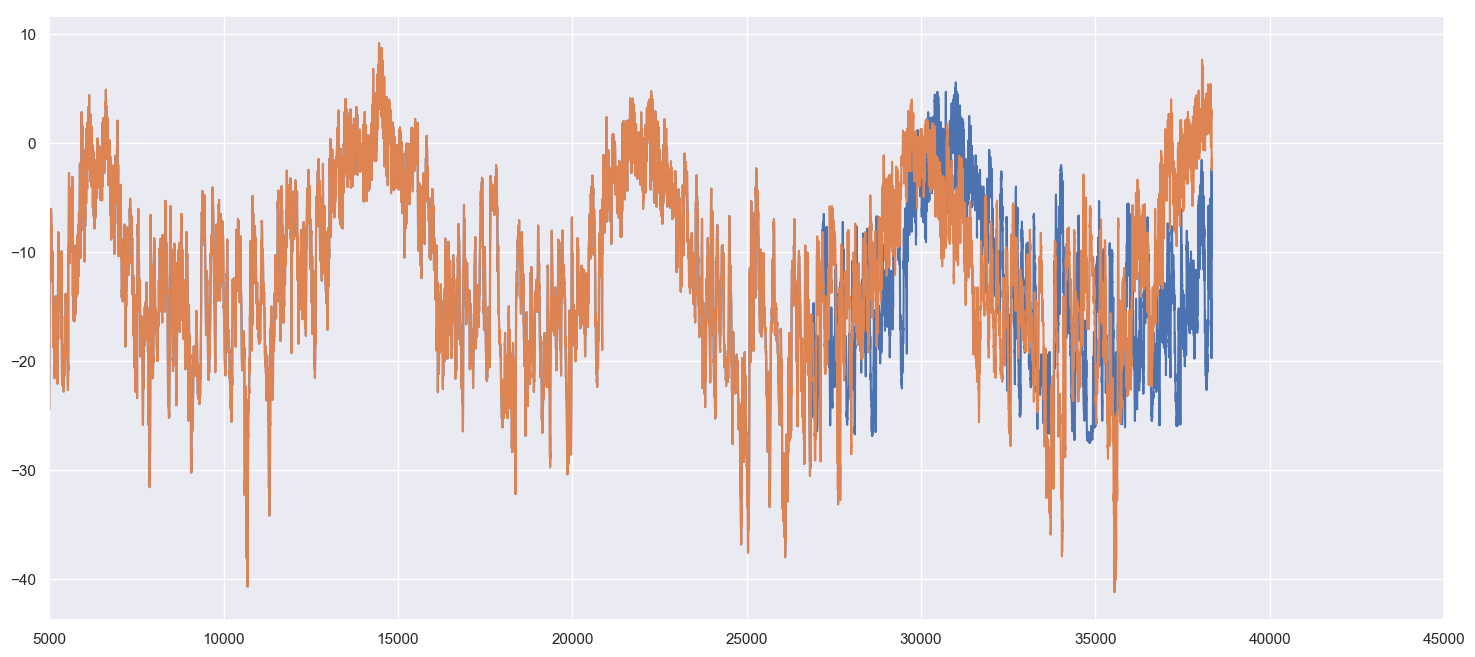

In [28]:
plt.xlim(5000,45000)
plt.plot(temp_values)
plt.plot(df.tempr.values)
plt.show()

In [29]:
print(pred.shape)

(11502,)


In [30]:
print(testX.shape)

(11502,)


In [31]:
RMSE=math.sqrt(mean_squared_error(pred,testX))

In [32]:
print(RMSE)

9.403975867062368
